In [38]:
# PACKAGES 
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import seaborn as sns
# Import tiingo for stock data
from tiingo import TiingoClient
# Import pandas-datareader for FRED data
import pandas_datareader.data as web
# Import requests for FMP API calls
import requests

In [40]:
# =============================================================================
# Function to pull stock data and dividends from Tiingo
# =============================================================================
def pullStockData(StockTickers, minDate, maxDate, interval='monthly', include_dividends=True):
    """
    Pull stock data and dividend information from Tiingo with robust error handling.
    """
    import pandas as pd
    import time
    from tiingo import TiingoClient
    
    # Configure Tiingo client
    config = {
        'api_key': "YOUR_TIINGO_API_KEY_HERE",  # Your Tiingo API key
        'session': True
    }
    client = TiingoClient(config)
    
    # Create DataFrames to hold the stocks and dividends pulled
    price_data = pd.DataFrame()
    dividend_data = pd.DataFrame() if include_dividends else None
    
    # Map interval to Tiingo frequency
    freq_map = {
        '1mo': 'monthly',
        'monthly': 'monthly',
        'weekly': 'weekly',
        'daily': 'daily'
    }
    tiingo_freq = freq_map.get(interval, 'monthly')
    
    # Format dates for API
    start_date = minDate.strftime('%Y-%m-%d')
    end_date = maxDate.strftime('%Y-%m-%d')
    
    count = 0
    outOf = len(StockTickers)
    
    # Pull each stock's data
    for stock in StockTickers:
        try:
            count += 1  # Keep track
            print(f'\nDownloading {stock} - Progress: {count} / {outOf}')
            
            # Get historical prices from Tiingo
            ticker_to_fetch = stock
            if stock.startswith('^'):
                # Remove ^ for index symbols in Tiingo
                ticker_to_fetch = stock[1:]
            
            # Get historical prices from Tiingo
            hist_data = client.get_ticker_price(
                ticker_to_fetch,
                fmt='json',
                startDate=start_date,
                endDate=end_date,
                frequency=tiingo_freq
            )
            
            if not hist_data or len(hist_data) == 0:
                print(f"No data returned from Tiingo for {stock}")
                continue
            
            # Convert to DataFrame and format
            stock_df = pd.DataFrame(hist_data)
            
            # Convert date string to datetime
            stock_df['date'] = pd.to_datetime(stock_df['date'])
            
            # Create properly formatted price data
            stock_price_data = pd.DataFrame({
                'stock': stock,
                'period': stock_df['date'],
                'adjClose': stock_df['adjClose'] if 'adjClose' in stock_df.columns 
                            else stock_df['close'] if 'close' in stock_df.columns
                            else None
            })
            
            # Check if adjClose was found
            if stock_price_data['adjClose'].isna().all():
                print(f"No price data found for {stock} in Tiingo response")
                continue
            
            # Add to price data
            price_data = pd.concat([price_data, stock_price_data])
            
            # Get dividend data if requested
            if include_dividends and 'divCash' in stock_df.columns:
                div_data = stock_df[stock_df['divCash'] > 0].copy()
                if not div_data.empty:
                    div_data = pd.DataFrame({
                        'stock': stock,
                        'date': div_data['date'],
                        'dividend': div_data['divCash']
                    })
                    dividend_data = pd.concat([dividend_data, div_data])
                    print(f"Downloaded {len(div_data)} dividend records for {stock}")
            
            # Add a slight delay to avoid rate limiting
            time.sleep(0.2)
            
        except Exception as e:
            print(f"Error processing {stock}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    # Drop any rows with missing values
    price_data = price_data.dropna()
    
    if include_dividends and dividend_data is not None and not dividend_data.empty:
        dividend_data = dividend_data.sort_values(by=['stock', 'date'])
    
    return (price_data, dividend_data) if include_dividends else price_data

In [42]:
# =============================================================================
# Function to get SPY benchmark data from Tiingo
# =============================================================================
def get_spy_benchmark(minDate, maxDate, include_dividends=True):
    """
    Fetch SPY ETF data as a benchmark for comparison.
    
    Returns:
        Tuple of (price_data, dividend_data) if include_dividends=True,
        otherwise just price_data
    """
    print("\nDownloading SPY benchmark data...")
    
    spy_data, spy_dividends = pullStockData(['SPY'], minDate, maxDate, include_dividends=include_dividends)
    
    # Format the data to match the expected structure
    spy_price_pivot = spy_data.pivot(index='period', columns='stock', values='adjClose')
    
    return (spy_price_pivot, spy_dividends) if include_dividends else spy_price_pivot

In [44]:
# =============================================================================
# Get risk-free rate (T-Bill data) from FRED
# =============================================================================
def get_risk_free_rate(minDate, maxDate):
    """
    Fetch the 3-Month Treasury Bill Rate (DTB3) directly from FRED.
    """
    import pandas_datareader.data as web
    
    try:
        print("\nDownloading T-Bill data from FRED...")
        
        # DTB3 is the 3-Month T-Bill secondary market rate
        data = web.DataReader('DTB3', 'fred', minDate, maxDate)
        
        if data.empty:
            print("No T-Bill data found from FRED. Using default rate of 2%.")
            return 0.02  # Default fallback
        
        # Get the average over the period and convert from percentage to decimal
        avg_rate = data.mean().values[0] / 100
        
        # Sanity check - rates should typically be between 0% and 10%
        if 0 <= avg_rate <= 0.1:
            print(f"Using FRED risk-free rate: {round(avg_rate * 100, 2)}%")
            return avg_rate
        else:
            print(f"Warning: T-Bill rate of {avg_rate*100:.2f}% from FRED seems unusual.")
            # Try different symbol if available
            try:
                # Try the 1-Month T-Bill rate as an alternative
                data_alt = web.DataReader('DTB4WK', 'fred', minDate, maxDate)
                if not data_alt.empty:
                    avg_rate_alt = data_alt.mean().values[0] / 100
                    if 0 <= avg_rate_alt <= 0.1:
                        print(f"Using alternative FRED risk-free rate: {round(avg_rate_alt * 100, 2)}%")
                        return avg_rate_alt
            except:
                pass  # If alternative fails, continue to default
                
            print("Using default rate of 2%.")
            return 0.02  # Default fallback
            
    except Exception as e:
        print(f"Error fetching risk-free rate from FRED: {e}")
        
        # Try an alternative approach - Treasury Constant Maturity 3 Month
        try:
            print("Trying alternative T-Bill symbol (GS3M)...")
            data = web.DataReader('GS3M', 'fred', minDate, maxDate)
            if not data.empty:
                avg_rate = data.mean().values[0] / 100
                if 0 <= avg_rate <= 0.1:
                    print(f"Using alternative FRED risk-free rate: {round(avg_rate * 100, 2)}%")
                    return avg_rate
        except Exception as e2:
            print(f"Alternative approach also failed: {e2}")
            
        print("Using default rate of 2%.")
        return 0.02  # Default fallback

In [46]:
# =============================================================================
# INPUT PARAMETERS (Optimized based on Test 5 results)
# =============================================================================

# MODIFICATION: Set explicit date range from 2012 to current date
minDate = dt.datetime(2012, 1, 1)  # Start from January 1, 2012
maxDate = dt.datetime.now()        # Current date

# List of Dividend Kings Stocks (MUST be Alphabetically Ordered)
StockTickers = [
   'ABBV', 'ABM', 'ABT', 'ADM', 'AWR', 'BDX', 'BKH', 'CBSH', 'CDUAF', 'CINF',
   'CL', 'CWT', 'DOV', 'ED', 'EMR', 'FMCB', 'FRT', 'FUL', 'GPC',
   'GRC', 'GWW', 'HRL', 'HTO', 'ITW', 'JNJ', 'KMB', 'KO', 'LOW',
   'MO', 'MSA', 'MSEX', 'NDSN', 'NFG', 'NUE', 'NWN', 'PEP', 'PG', 'PH',
   'PPG', 'RPM', 'SCL', 'SPGI', 'SWK', 'SYY', 'TGT', 'TNC', 'TR',
   'UBSI', 'UVV', 'WMT'
]

# Optimized parameters based on Test 5 results
totalIterations  = 1000     # Main Stopping criteria = the total number of iterations ___USER!!
evalGoal         = 'sharpe'    # Minimize 'risk' or maximize 'sharpe' ______USER!!
minDesiredReturn = 0.00    # Meet the minimum desired return. E.g. 7.5%_____USEER!!
numPorfolios     = 200       # Number of portfolios in swarm to simulate ___USEER!!
method           = 'local'   # 'local' or 'global' best function name ___USEER!!

# Helper Inputs 
# -----------------------------------------------------------------------------
MONTHS_IN_YEAR = 12 # The number of months in a year

# Bounds for evaluation Function search space
lowerBound        = 0   # No weight in a stock
upperBound        = 1   # Max weight in stock

# Set up Tiingo API client globally for reuse
config = {
    'api_key': "YOUR_TIINGO_API_KEY_HERE",  # Your Tiingo API key
    'session': True
}
tiingo_client = TiingoClient(config)

# Use the risk-free rate function to get the rate from FRED
riskFreeRate = get_risk_free_rate(minDate, maxDate)


Using FRED risk-free rate: 1.5%


In [48]:
# =============================================================================
# Get Market Cap and Industry Data from FMP
# =============================================================================
def get_fmp_market_cap_and_industry_data(StockTickers, api_key=None):
    """
    Fetches market capitalization and industry classification data from FMP.
    
    Parameters:
    - StockTickers: List of stock tickers
    - api_key: FMP API key (required)
    
    Returns:
    - Tuple of (market_caps, industry_groups) as pandas Series
    """
    import pandas as pd
    import requests
    import time
    
    # Ensure API key is provided
    if api_key is None:
        print("FMP API key is required. Please provide a valid API key.")
        return pd.Series(), pd.Series()
    
    market_caps = {}
    industries = {}
    
    print("\nFetching market cap and industry data from Financial Modeling Prep...")
    
    # Get company profiles (contains both market cap and industry)
    for i, ticker in enumerate(StockTickers):
        try:
            # Build the API URL
            url = f"https://financialmodelingprep.com/api/v3/profile/{ticker}?apikey={api_key}"
            
            # Make the request
            response = requests.get(url)
            
            # Check for successful response
            if response.status_code == 200:
                data = response.json()
                
                if data and len(data) > 0:
                    company = data[0]  # FMP returns a list with one item
                    
                    # Extract market cap
                    if 'mktCap' in company and company['mktCap'] is not None:
                        market_caps[ticker] = float(company['mktCap'])
                    
                    # Extract industry
                    if 'industry' in company and company['industry'] is not None:
                        industries[ticker] = company['industry']
                    elif 'sector' in company and company['sector'] is not None:
                        industries[ticker] = company['sector']  # Fallback to sector if industry is missing
                else:
                    print(f"No profile data found for {ticker}")
            else:
                print(f"Error fetching data for {ticker}: HTTP {response.status_code}")
            
            # Add a slight delay to avoid rate limiting
            time.sleep(0.25)
            
            # Print progress
            if (i + 1) % 10 == 0 or (i + 1) == len(StockTickers):
                print(f"Processed {i + 1}/{len(StockTickers)} tickers")
                
        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
    
    print(f"\nSuccessfully retrieved market cap data for {len(market_caps)}/{len(StockTickers)} tickers")
    print(f"Successfully retrieved industry data for {len(industries)}/{len(StockTickers)} tickers")
    
    # Convert to pandas Series
    market_caps_series = pd.Series(market_caps)
    industries_series = pd.Series(industries)
    
    return market_caps_series, industries_series

In [50]:
# =============================================================================
# Import stocks (monthly)
# =============================================================================

# Set up Tiingo API client globally for reuse (keep this from your original code)
config = {
    'api_key': "YOUR_TIINGO_API_KEY_HERE",  # Your Tiingo API key
    'session': True
}
tiingo_client = TiingoClient(config)

# Use the risk-free rate function from your existing code
riskFreeRate = get_risk_free_rate(minDate, maxDate)

# Pull in stock price data using your existing Tiingo function
print("\nPulling data for all stocks...")
RawStockData, dividend_data = pullStockData(StockTickers, minDate, maxDate)

# NEW: Get market cap and industry data from FMP instead of Tiingo
FMP_API_KEY = "YOUR_FMP_API_KEY_HERE"  # Replace with your actual FMP API key
market_caps, industry_groups = get_fmp_market_cap_and_industry_data(StockTickers, api_key=FMP_API_KEY)

# Make market caps and industry groups accessible for Bayesian shrinkage
if not market_caps.empty:
    print(f"Successfully loaded market cap data for {len(market_caps)} stocks (will be used for Bayesian shrinkage)")
else:
    print("Warning: No market cap data available. Bayesian shrinkage will use global priors only.")

if not industry_groups.empty:
    print(f"Successfully loaded industry classification data for {len(industry_groups)} stocks")
else:
    print("Warning: No industry data available. Bayesian shrinkage will not use industry-specific priors.")

# Continue with your existing code
print("\nVerifying data date range:")
pivot_data = RawStockData.pivot(index='period', columns='stock', values='adjClose')
print(f"Data range: {pivot_data.index.min()} to {pivot_data.index.max()}")
print(f"Number of time periods: {len(pivot_data)}")

# Pivot so that each stock is its own column
RawStockDataPivot = RawStockData.copy().pivot(index='period', columns='stock', values='adjClose')
RawStockDataPivot.to_csv('DividendKingsDataPivot.csv')


Using FRED risk-free rate: 1.5%

Pulling data for all stocks...

Downloaded 51 dividend records for ABBV

Downloaded 55 dividend records for ABM

Downloaded 55 dividend records for ABT

Downloaded 54 dividend records for ADM

Downloaded 54 dividend records for AWR

Downloaded 54 dividend records for BDX

Downloaded 54 dividend records for BKH

Downloaded 54 dividend records for CBSH

Downloaded 53 dividend records for CDUAF

Downloaded 55 dividend records for CINF

Downloaded 55 dividend records for CL

Downloaded 54 dividend records for CWT

Downloaded 54 dividend records for DOV

Downloaded 54 dividend records for ED

Downloaded 54 dividend records for EMR

Downloaded 27 dividend records for FMCB

Downloaded 54 dividend records for FRT

Downloaded 54 dividend records for FUL

Downloaded 54 dividend records for GPC

Downloaded 54 dividend records for GRC

Downloaded 54 dividend records for GWW

Downloaded 55 dividend records for HRL

Downloaded 54 dividend records for HTO

Downloaded

In [52]:
# =============================================================================
# FACTOR MODEL FOR COVARIANCE MATRIX (SINGLE-INDEX)
# =============================================================================

def build_factor_covariance_with_blume(returns_df, market_returns, tickers, blume_weight=0.67):
    """
    Computes a single-index (factor model) covariance matrix with Blume-adjusted betas.

    Parameters:
    - returns_df: pd.DataFrame of stock returns (time x stocks)
    - market_returns: pd.Series of market returns (e.g., SPY or ^GSPC)
    - tickers: list of tickers (to preserve order)
    - blume_weight: float (default = 0.67), for Blume beta adjustment

    Returns:
    - factor_cov_matrix: pd.DataFrame (n x n) - estimated covariance matrix
    - adjusted_betas: pd.Series (length n) - Blume-adjusted betas
    - residual_vars: pd.Series (length n) - residual variances
    """
    from sklearn.linear_model import LinearRegression
    import numpy as np
    import pandas as pd

    betas = []
    residual_vars = []

    # Align dates to avoid missing data mismatches
    returns_df = returns_df.copy()
    market_returns = market_returns.copy()
    aligned_index = returns_df.index.intersection(market_returns.index)
    returns_df = returns_df.loc[aligned_index]
    market_returns = market_returns.loc[aligned_index]

    # Regress each stock on the market
    for ticker in tickers:
        X = market_returns.values.reshape(-1, 1)
        y = returns_df[ticker].values
        reg = LinearRegression().fit(X, y)
        beta_hat = reg.coef_[0]
        residuals = y - reg.predict(X)
        sigma_e = np.var(residuals, ddof=1)  # Use unbiased variance estimator

        betas.append(beta_hat)
        residual_vars.append(sigma_e)

    # Apply Blume adjustment to betas with numerical stability
    epsilon = 1e-8
    raw_betas = pd.Series(betas, index=tickers)
    adjusted_betas = blume_weight * raw_betas + (1 - blume_weight) * 1.0
    adjusted_betas = adjusted_betas.clip(lower=epsilon)  # Prevent near-zero or negative betas

    residual_vars = pd.Series(residual_vars, index=tickers)

    # Use unbiased sample variance for market returns (correct calculation of σ²m)
    sigma_m = np.cov(market_returns, bias=False).item()

    # Build the covariance matrix
    n = len(tickers)
    cov_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            cov_matrix[i, j] = adjusted_betas[i] * adjusted_betas[j] * sigma_m
            if i == j:
                cov_matrix[i, j] += residual_vars.iloc[i]

    factor_cov_matrix = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)

    return factor_cov_matrix, adjusted_betas, residual_vars


In [54]:
# =============================================================================
# Manipulate stock data
# Create Returns, ExcessReturns, and ExpectedReturns data frames
# Using section 10.2 of Financial Modeling, 4th ed., Benninga
# =============================================================================

# 1. Get the percent return for each stock, for each period
# -- Calculation: Returns = This period return divided by last period minus 1, for each stock
# -----------------------------------------------------------------------------

# 1. Get the percent return for each stock, for each period
# Create a data frame for the returns using raw data
Returns = RawStockDataPivot.copy()

# % Return = Percent change from last period to period + 1
Returns = Returns.pct_change()

# Instead of dropping all rows with NaN values, fill them with column means
for col in Returns.columns:
    Returns[col] = Returns[col].fillna(Returns[col].mean())

# Print debug info about returns data
print(f"Returns data covers {Returns.index.min()} to {Returns.index.max()}")
print(f"Number of periods in Returns data: {len(Returns)}")
# -----------------------------------------------------------------------------

# Using the Returns data
ExpectedReturns = Returns.copy()

# Group by all periods and get the mean
ExpectedReturns['AllPeriods'] = 'AllPeriods'
ExpectedReturns = ExpectedReturns.groupby('AllPeriods').mean()

# 3. Calculate the Excess Returns for each stock and month
# -- Calculation: ExcessReturns = Returns - ExpectedReturns, for each stock
# -----------------------------------------------------------------------------

ExcessReturns = Returns.copy() - np.array(ExpectedReturns)

# 4. Variance-Covariance Matrix
# -- Calculation: Factor model with Blume-adjusted betas
# -----------------------------------------------------------------------------
# Number of periods in sample
numPeriods = len(ExcessReturns.index)

# Fetch market index data using Tiingo for factor model
print("\nFetching market index data (S&P 500) for factor model...")
spy_data, _ = pullStockData(['SPY'], minDate, maxDate)
spy_price_data = spy_data.pivot(index='period', columns='stock', values='adjClose')
market_returns = spy_price_data['SPY'].pct_change().dropna()
aligned_returns = Returns.loc[Returns.index.intersection(market_returns.index)]

# Calculate factor-based covariance matrix with Blume-adjusted betas
VarCov, adj_betas, resid_vars = build_factor_covariance_with_blume(
    aligned_returns,
    market_returns,
    StockTickers,
    blume_weight=0.67  # Default Blume adjustment weight
)
print(f"Created factor model covariance matrix using {len(aligned_returns)} aligned periods")

Returns data covers 2012-01-31 00:00:00+00:00 to 2025-07-31 00:00:00+00:00
Number of periods in Returns data: 163

Fetching market index data (S&P 500) for factor model...

Downloaded 54 dividend records for SPY
Created factor model covariance matrix using 162 aligned periods


C:\Users\Alexander\AppData\Local\Temp\ipykernel_23960\3361094082.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cov_matrix[i, j] = adjusted_betas[i] * adjusted_betas[j] * sigma_m


In [56]:
# =============================================================================
# Functions to Evaluate Risk, Expected Return, and Sharpe Ratio
# =============================================================================

# Function to Calculate the ExpectedReturn
# -- Calculation: expectedReturn = MONTH_IN_YEAR * ( Weights * t(ExpectedReturns) )
# -----------------------------------------------------------------------------
def evalExpectedReturn(MONTHS_IN_YEAR, Weights, ExpectedReturns):
    """Calculate the expected annualized return of a portfolio."""
    # Convert to numpy array - use EXACTLY the same approach as original
    Weights = np.array(Weights)    
    
    # Use same calculation as original
    expectedReturn = MONTHS_IN_YEAR * (Weights.dot(ExpectedReturns.transpose()))
    
    # Return first element - CRITICAL to handle array result
    if isinstance(expectedReturn, np.ndarray):
        return expectedReturn[0]
    return expectedReturn

# ADD THE TWO MISSING FUNCTIONS HERE:
# Function to Calculate the Risk
def evalRisk(MONTHS_IN_YEAR, Weights, VarCov, ExpectedReturns, minDesiredReturn):
    
    # convert to numpy array
    Weights = np.array(Weights)
    
    # IF not the return desired then put a penalty on the portfolio
    # if evalExpectedReturn(MONTHS_IN_YEAR, Weights, ExpectedReturns) < minDesiredReturn:
    #     risk = 9999 # large penalty
        
    # # Else if desired return, then return actual risk
    # else:
    risk = np.sqrt(MONTHS_IN_YEAR) * np.sqrt( ( Weights.dot(VarCov) ).dot( Weights.transpose() ) )
    
    return risk


# Function to Calculate the SharpeRatio
# -- Calculation: (expectedReturn - riskFreeRate) / risk 
# -----------------------------------------------------------------------------
def evalSharpeRatio(expectedReturn, riskFreeRate, risk):
    
    sharpeRatio = ( expectedReturn - riskFreeRate ) / risk 
    return sharpeRatio

In [58]:
# =============================================================================
# DYNAMIC BAYESIAN SHRINKAGE 1.0 
# =============================================================================

def apply_dynamic_bayesian_shrinkage(ExpectedReturns, Returns, market_caps=None, industry_groups=None, 
                                    global_prior_mean=None, global_prior_variance=None,
                                    use_asset_specific_priors=True, return_posterior_variance=False):
    """
    Applies advanced Bayesian Shrinkage to expected returns using either:
    1. Classic James-Stein shrinkage with a global prior (when use_asset_specific_priors=False)
    2. Asset-specific priors based on market cap and/or industry groups (when use_asset_specific_priors=True)
    
    Parameters:
    - ExpectedReturns: pd.DataFrame (1 row, n columns) - historical sample means
    - Returns: pd.DataFrame (time x n columns) - historical returns data
    - market_caps: pd.Series or dict - market capitalizations for each asset (optional)
    - industry_groups: pd.Series or dict - industry classification for each asset (optional)
    - global_prior_mean: float or None - if None, uses the mean of ExpectedReturns
    - global_prior_variance: float or None - if None, uses cross-sectional variance of ExpectedReturns
    - use_asset_specific_priors: bool - whether to use asset-specific priors based on provided data
    - return_posterior_variance: bool - whether to return posterior variances alongside adjusted returns
    
    Returns:
    - pd.DataFrame of adjusted expected returns (posterior mean estimates)
    - Optionally, pd.Series of posterior variances if return_posterior_variance is True
    """
    import numpy as np
    import pandas as pd
    
    # Small constant to prevent division by zero
    epsilon = 1e-8
    
    # Get the sample means and variances
    sample_means = ExpectedReturns.iloc[0].copy()
    sample_variances = Returns.var()
    n_obs = len(Returns)
    
    # Initialize prior means using empirical Bayes approach
    if global_prior_mean is None:
        global_prior_mean = sample_means.mean()
    
    # More robust prior variance calculation using empirical Bayes
    if global_prior_variance is None:
        global_prior_variance = np.var(sample_means.values - global_prior_mean)
    
    # Default case: Classic James-Stein shrinkage with global prior
    if not use_asset_specific_priors or (market_caps is None and industry_groups is None):
        # Use classic James-Stein formula: λ = σ²_prior / (σ²_prior + σ²_sample/n)
        shrinkage_factors = global_prior_variance / (global_prior_variance + sample_variances / n_obs + epsilon)
        
        # Apply confidence-weighted adjustment for improved precision
        standard_errors = np.sqrt(sample_variances / (n_obs + epsilon))
        confidence_weights = 1 / (1 + standard_errors + epsilon)
        shrinkage_factors *= confidence_weights
        
        # Ensure shrinkage factors are between 0 and 1
        shrinkage_factors = np.clip(shrinkage_factors, 0, 1)
        
        # Calculate adjusted expected returns
        adjusted_returns = (1 - shrinkage_factors) * sample_means + shrinkage_factors * global_prior_mean
    
    # Advanced case: Asset-specific priors based on market cap and/or industry groups
    else:
        adjusted_returns = sample_means.copy()
        asset_prior_means = pd.Series(global_prior_mean, index=sample_means.index)
        
        # 1. Adjust prior means based on market cap if available
        if market_caps is not None:
            # Convert to Series if dict
            if isinstance(market_caps, dict):
                market_caps = pd.Series(market_caps)
                
            # Group assets into size buckets (small, medium, large cap)
            market_cap_quantiles = market_caps.quantile([0.33, 0.67])
            small_cap = market_caps[market_caps <= market_cap_quantiles[0.33]].index
            mid_cap = market_caps[(market_caps > market_cap_quantiles[0.33]) & 
                                 (market_caps <= market_cap_quantiles[0.67])].index
            large_cap = market_caps[market_caps > market_cap_quantiles[0.67]].index
            
            # Calculate size-specific prior means
            small_cap_mean = sample_means.loc[small_cap].mean() if len(small_cap) > 0 else global_prior_mean
            mid_cap_mean = sample_means.loc[mid_cap].mean() if len(mid_cap) > 0 else global_prior_mean
            large_cap_mean = sample_means.loc[large_cap].mean() if len(large_cap) > 0 else global_prior_mean
            
            # Assign prior means based on size
            asset_prior_means.loc[small_cap] = small_cap_mean
            asset_prior_means.loc[mid_cap] = mid_cap_mean
            asset_prior_means.loc[large_cap] = large_cap_mean
        
        # 2. Adjust prior means based on industry groups if available
        if industry_groups is not None:
            # Convert to Series if dict
            if isinstance(industry_groups, dict):
                industry_groups = pd.Series(industry_groups)
                
            # Calculate industry-specific prior means
            industry_means = {}
            for industry in industry_groups.unique():
                industry_assets = industry_groups[industry_groups == industry].index
                if len(industry_assets) > 0:
                    industry_means[industry] = sample_means.loc[industry_assets].mean()
                else:
                    industry_means[industry] = global_prior_mean
            
            # Blend with market cap-based priors (50/50 weight) if market_caps were used
            if market_caps is not None:
                for asset in sample_means.index:
                    industry = industry_groups.get(asset, None)
                    if industry in industry_means:
                        asset_prior_means[asset] = 0.5 * asset_prior_means[asset] + 0.5 * industry_means[industry]
            else:
                # Use only industry-based priors
                for asset in sample_means.index:
                    industry = industry_groups.get(asset, None)
                    if industry in industry_means:
                        asset_prior_means[asset] = industry_means[industry]
        
        # Calculate asset-specific shrinkage factors using classic formula
        shrinkage_factors = global_prior_variance / (global_prior_variance + sample_variances / n_obs + epsilon)
        
        # Apply confidence-weighted adjustment for improved precision
        standard_errors = np.sqrt(sample_variances / (n_obs + epsilon))
        confidence_weights = 1 / (1 + standard_errors + epsilon)
        shrinkage_factors *= confidence_weights
        
        shrinkage_factors = np.clip(shrinkage_factors, 0, 1)
        
        # Apply shrinkage with asset-specific priors
        adjusted_returns = (1 - shrinkage_factors) * sample_means + shrinkage_factors * asset_prior_means
    
    # Calculate posterior variances if requested
    if return_posterior_variance:
        posterior_variances = 1 / (1 / (global_prior_variance + epsilon) + n_obs / (sample_variances + epsilon))
        return pd.DataFrame([adjusted_returns], columns=ExpectedReturns.columns), posterior_variances
    
    # Return as DataFrame to match ExpectedReturns format
    return pd.DataFrame([adjusted_returns], columns=ExpectedReturns.columns)

In [60]:
# =============================================================================
# Metaheuristic Support Functions to Optimize Portfolio
# =============================================================================

# Fixed evalFunction with precise solution for the error at line 18
def evalFunction(Weights, evalGoal='risk'):
    
    # For every portfolio portfolio, calculate the fitness value based on evaluation function
    
    ## Calculate the risk
    risk = evalRisk(MONTHS_IN_YEAR, Weights, VarCov, ExpectedReturns, minDesiredReturn)
    
    ## Calculate the expected return
    expectedReturn = evalExpectedReturn(MONTHS_IN_YEAR, Weights, ExpectedReturns)

    fitnessValue = 0 # initialize the output variable

    # Evaluate using the risk (minimize the risk of portfolio)
    if evalGoal == 'risk':
        fitnessValue = risk
    
    # Else use the sharpe ratio (maximize the sharpe ratio of portfolio):
    # Note changed signs because we want to dynamically maximize
    else: 
        # Calculate proper Sharpe ratio
        sharpeRatio = evalSharpeRatio(expectedReturn, riskFreeRate, risk)
        fitnessValue = -sharpeRatio  # Negative sign for maximization

    return fitnessValue

# GLOBAL MIN VALUE AND POSITION SEARCH FUNCTION
def getGlobalBest(FitnessValues, Weights, numPorfolios):
    if isinstance(FitnessValues, (float, np.float64, np.float32)):
        # It's already a scalar value
        return [FitnessValues, Weights]
    
    minValue = np.min(FitnessValues)         # Find the Minimum fitness value of all portfolios
    minIndex = FitnessValues.index(minValue) # Find the index of the Weights for the min. fit. value
    
    minPosition = Weights[minIndex][:] # Now get a copy of the portfolio's Weights with min index
    
    # Returns: the global best portfolio's minimum fitness value and its Weights
    return [minValue, minPosition]

# LOCAL MIN VALUE AND POSITION SEARCH FUNCTION
def getLocalBest(FitnessValues, Weights, numPorfolios, numStocksInNbrhd=2):
    lBestFitValue = [] # will hold the best VALUE of the n surrounding portfolios, for each portfolio
    lBestPosition = [] # will hold the best POSITION of the n surrounding portfolios, for each portfolio
    
    # For every portfolio in the portfolio swarm, (starting at n less than index 0)
    for portfolio in range(-numStocksInNbrhd, numPorfolios - numStocksInNbrhd):
        # Identify the two neighbors fitness value of this portfolio
        personalBestNeighbor1 = FitnessValues[portfolio]
        personalBestNeighbor2 = FitnessValues[portfolio + 1]
        
        # Identify the lowest fitness value of this portfolio's the two preceding neighbors
        minNeighValue = min(personalBestNeighbor1, personalBestNeighbor2)
        
        # Store the index of the portfolio
        minNeighIndex = FitnessValues.index(minNeighValue)
        
        # Store the portfolio's best neighbors fitness value and Weights
        lBestFitValue.append(FitnessValues[minNeighIndex])
        lBestPosition.append(Weights[minNeighIndex])
        
    # Returns a list of portfolios and the min of their n best fit. valued neighbors
    return [lBestFitValue, lBestPosition]

# Constant indices for accessing best values and positions
VALUE_IDX = 0
POSITION_IDX = 1

# SWARM INITIALIZATION / EVALUATION
def initializeSwarm(numPorfolios, numStocksInPort, functionToGetBest, evalGoal, absoluteMoveLimit):
    
    # In the current time period, Weights[portfolio] and Velocity[portfolio] of each portfolio i, 
    Weights  = [] # to hold the portfolio weights
    Velocity = [] # to hold the portfolio velocities

    # Lists containing info related to each portfolio in portfolio swarm
    pCurrFitValue = []  # X[portfolio] The current Weights of portfolio i
    
    # For each portfolio and stock, randomly initialize the...
    for portfolio in range(numPorfolios):
        # for stock in range(numStocksInPort):
            
        # Create a random feasible solution
        randomValues = np.random.rand(numStocksInPort)
        randomWeights = randomValues / sum(randomValues)
        
        # For risk optimization, ensure that it meets return constraint
        # For sharpe optimization, we don't need a return constraint
        if evalGoal == 'risk':
            while evalExpectedReturn(MONTHS_IN_YEAR, randomWeights, ExpectedReturns) < minDesiredReturn:
                randomValues = np.random.rand(numStocksInPort)
                randomWeights = randomValues / sum(randomValues)
         
        # Position: give random solution of weights summing to 1
        Weights.append(randomWeights)
        
        # Velocity: give random value between lower and upper bound
        Velocity.append(np.random.rand(numStocksInPort) * absoluteMoveLimit)
    
        # 1.1 - Evaluate fitness value
        pCurrFitValue.append(evalFunction(Weights[-1], evalGoal))  # evaluate the current Weights's fitness value
        
    # 1.2 - Log the individual and global bests
    pBestPosition = Weights[:]       # initialize pBestPosition to the starting Weights
    pBestFitValue = pCurrFitValue[:]  # initialize pBestPosition to the starting Weights's value

    # 1.3 - Log the Global or local best (depends on chosen method) fitness value and Weights
    glBestFitValue, glBestPosition = functionToGetBest(pBestFitValue[:], pBestPosition[:], numPorfolios) 
    
    return [Weights, Velocity, pCurrFitValue, 
            pBestPosition, pBestFitValue, 
            glBestFitValue, glBestPosition]

# UPDATE VELOCITY AND POSITION
def updateVelocityAndWeights(intertiaWeight, Velocity, Weights, phi1, phi2, pBestPosition, glBestPosition,
                              numPorfolios, numStocksInPort, absoluteMoveLimit):
# Velocity --------------------------------------------------------------------
    
    ## random weights of r for random Velocity adjustment
    r1, r2 = np.random.rand(), np.random.rand() 
    
    ## Calculations of updating Velocity, separated by 
    ## intertia + cognitive + social (for simplicity)
    vInertia   = np.multiply(intertiaWeight, Velocity[:])                          # Interia   component of updated Velocity
    vCognitive = np.multiply(phi1*r1, np.subtract( pBestPosition[:], Weights[:])) # Cognitive component of ""
    vSocial    = np.multiply(phi2*r2, np.subtract(glBestPosition[:], Weights[:])) # Social    component of ""
    
    ## Update the new Velocity to the summation of intertia, cognitive, and social
    newVelocity =  vInertia[:] + vCognitive[:] + vSocial[:]
    
    ## Limit the Velocity between the upper and lower bound limits
    for portfolio in range(numPorfolios):
        for stock in range(numStocksInPort):
        
            # If the new Velocity of portfolio i is > the ub move limit, then reduce to the limit
            if newVelocity[portfolio][stock] > absoluteMoveLimit:
                newVelocity[portfolio][stock] = absoluteMoveLimit
                
            # If the new Velocity of portfolio i is < the limit, then increase to the limit
            if newVelocity[portfolio][stock] < -absoluteMoveLimit:
                newVelocity[portfolio][stock] = -absoluteMoveLimit
        
    # Position ----------------------------------------------------------------
    
    ## Update new Weights based on the updated Velocity
    newWeights = Weights[:] + newVelocity[:] 
    
    
    ## Make sure that the Weights is within the bounds -----------------------
    
    # For each portfolio and stock
    for portfolio in range(numPorfolios):
        for stock in range(numStocksInPort):
            
            # Push the new Weights to lower bound if lower
            if newWeights[portfolio][stock] < lowerBound:
                newWeights[portfolio][stock] = lowerBound
            
            # Push the new Weights to upper bound if higher
            if newWeights[portfolio][stock] > upperBound:
                newWeights[portfolio][stock] = upperBound

        
    for portfolio in range(numPorfolios):
            
        # Balance the weights to equal 1.
        # Be sure to keep move limit close to 1
        newWeights[portfolio] = np.array(newWeights[portfolio]) / sum(newWeights[portfolio])
        
    
    # Convert Weights and Velocity back to list ------------------------------
    newWeights  = newWeights.tolist()
    newVelocity = newVelocity.tolist()
    
    return [newWeights, newVelocity]

# Fixed calculatePortfolioBests function
def calculatePortfolioBests(Weights, numPorfolios, numStocksInPort,
                           pCurrFitValue, pBestPosition, pBestFitValue, evalGoal):
    # Calculate the fitness of the new Weights
    for portfolio in range(numPorfolios):
        # for stock in range(numStocksInPort):
            
        # Get the current fitness value of the new Weights
        pCurrFitValue[portfolio] = evalFunction(Weights[:][portfolio], evalGoal)
        
        # Compare the current Weights' value to their person best
        if pCurrFitValue[portfolio] < pBestFitValue[portfolio]:
        
            # If better, then set the best VALUE to the current value (as a copy [:])
            pBestFitValue[portfolio] = pCurrFitValue[:][portfolio]
            
            # If better, then set the best POSITION to the current Weights  (as a copy [:])
            pBestPosition[portfolio] = Weights[:][portfolio]
    
    return [pCurrFitValue, pBestPosition, pBestFitValue]

# DISPLAY GLOBAL BEST AND DIMENSIONS FUNCTION
def displayGlobalBest(glBestFitValue, glBestPosition, numStocksInPort, printDims, StockTickers, expectedReturn,
                     riskFreeRate, evalGoal, numPeriods=numPeriods, MONTHS_IN_YEAR=MONTHS_IN_YEAR):
    
    # The sharpe ratio
    sharpeRatio = evalSharpeRatio(expectedReturn, riskFreeRate, glBestFitValue)

    # Total % return over the entire period
    monthsInSample = numPeriods / MONTHS_IN_YEAR # since on monthly basis
    returnOverPeriod = (1 + expectedReturn) ** monthsInSample
    
    # Print the global optima
    print('\n```')
    print('Key Summary Statistics -----------------')
    
    if evalGoal == 'risk':
        print('Global Best Annualized Risk:\t', str(round(100 * glBestFitValue, 1)) + '%')
        print('Annualized Expected Return:\t', str(round(100 * expectedReturn, 1)) + '%')
        print('Sharpe Ratio:\t\t\t% 0.2f' % sharpeRatio)
    else:  # sharpe
        print('Global Best Sharpe Ratio:\t% 0.2f' % sharpeRatio)
        print('Annualized Expected Return:\t', str(round(100 * expectedReturn, 1)) + '%')
        print('Annualized Risk:\t\t', str(round(100 * glBestFitValue, 1)) + '%')
    
    print('Expected Return over', str(round(monthsInSample, 1)), 'Years:', str(round(100 * returnOverPeriod, 1)) + '%')
    
    # Print each stock (if toggled)
    if printDims:
        print('\nGlobal best weights in each stock (Only includes stocks to invest in):')
        print('```')
        
        # Print the Weights of each stock in markdown table format
        print('| Ticker | Opt. Weight |')
        print('|--------|-------------|')
        for stock in range(numStocksInPort):
            if glBestPosition[stock] > 0.001:  # Only show stocks with weight > 0.1%
                print('|' + str(StockTickers[stock]).rjust(7, ' '), 
                      '|' + '{:.1f}'.format(100 * round(glBestPosition[stock], 3)).rjust(11, ' ') + '% |')

# Plot the optimal weights and prices performance
def plotOptimalPerformance(RawStockDataPivot, OptimalWeights, spy_data=None):
    """
    Plot the performance of the optimized portfolio with SPY benchmark comparison
    and equal-weighted portfolio, all normalized to the same starting value.
    """
    # First handle NaN values in the raw data
    filled_data = RawStockDataPivot.copy()
    
    # Fill NaN values with column means for plotting purposes
    for col in filled_data.columns:
        filled_data[col] = filled_data[col].ffill().bfill()
    
    # Calculate the weighted prices without dropping NaN values
    OptimizedPrices = filled_data.dot(OptimalWeights)
    
    # Calculate equal-weighted portfolio
    equal_weights = np.ones(len(filled_data.columns)) / len(filled_data.columns)
    EqualWeightedPrices = filled_data.dot(equal_weights)
    
    # Find common starting date
    start_date = OptimizedPrices.index.min()
    
    # Get starting values
    optimized_start_value = OptimizedPrices.loc[start_date]
    equal_weighted_start_value = EqualWeightedPrices.loc[start_date]
    
    # Normalize equal-weighted portfolio to start at the same value as optimized portfolio
    normalized_equal_weighted = EqualWeightedPrices * (optimized_start_value / equal_weighted_start_value)
    
    # Print debug info to verify data range before plotting
    print(f"Plotting data from {OptimizedPrices.index.min()} to {OptimizedPrices.index.max()}")
    print(f"Number of data points to plot: {len(OptimizedPrices)}")
    print(f"Starting value - Optimized: {optimized_start_value:.2f}, Equal-Weighted: {equal_weighted_start_value:.2f}")
    print(f"After normalization - Equal-Weighted starts at: {normalized_equal_weighted.iloc[0]:.2f}")
    
    # Create a plot
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    # Plot the weighted prices
    ax.plot(OptimizedPrices, label='Optimized Portfolio', color='blue')
    
    # Plot the normalized equal-weighted portfolio
    ax.plot(normalized_equal_weighted, label='Equal-Weighted Portfolio', color='orange')
    
    # Add SPY benchmark if provided
    if spy_data is not None:
        # Normalize SPY prices to start at the same value as the portfolio
        common_dates = OptimizedPrices.index.intersection(spy_data.index)
        if not common_dates.empty:
            start_date = common_dates.min()
            spy_series = spy_data.loc[common_dates, 'SPY']
            
            # Normalize to the same start value for fair comparison
            normalized_spy = spy_series * (OptimizedPrices.loc[start_date] / spy_series.loc[start_date])
            ax.plot(normalized_spy, label='S&P 500 ETF (SPY)', color='green', linestyle='--')
    
    # Explicitly set the x-axis limits to show all data
    plt.xlim(OptimizedPrices.index.min(), OptimizedPrices.index.max())
    
    # Labels and formatting
    ax.set_title("Wt.'d Monthly Adj. Close Price of Optimal Dividend Kings Portfolio (2012-Present)")
    ax.set_xlabel('Month of Year')
    ax.set_ylabel('Weighted Adj. Close Price (USD)')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('DividendKingsOptimalPortfolio_WithBenchmarks.png')
    plt.show()
    
    # Calculate and display performance metrics
    if spy_data is not None:
        print("\n=== Performance Comparison ===")
        
        # Calculate returns for optimized portfolio
        port_returns = OptimizedPrices.pct_change().dropna()
        port_cum_return = (1 + port_returns).cumprod().iloc[-1] - 1
        port_annual_return = ((1 + port_cum_return) ** (1 / (len(port_returns) / 12))) - 1
        
        # Calculate returns for equal-weighted portfolio
        equal_returns = EqualWeightedPrices.pct_change().dropna()
        equal_cum_return = (1 + equal_returns).cumprod().iloc[-1] - 1
        equal_annual_return = ((1 + equal_cum_return) ** (1 / (len(equal_returns) / 12))) - 1
        
        print(f"Optimized Portfolio: Total Return: {port_cum_return:.2%}, Annual: {port_annual_return:.2%}")
        print(f"Equal-Weighted Portfolio: Total Return: {equal_cum_return:.2%}, Annual: {equal_annual_return:.2%}")
        
        # Calculate SPY performance if available
        common_dates = OptimizedPrices.index.intersection(spy_data.index)
        if not common_dates.empty:
            spy_series = spy_data.loc[common_dates, 'SPY']
            spy_returns = spy_series.pct_change().dropna()
            spy_cum_return = (1 + spy_returns).cumprod().iloc[-1] - 1
            spy_annual_return = ((1 + spy_cum_return) ** (1 / (len(spy_returns) / 12))) - 1
            
            print(f"S&P 500 ETF (SPY): Total Return: {spy_cum_return:.2%}, Annual: {spy_annual_return:.2%}")
            print(f"Optimized vs SPY Outperformance: {port_cum_return - spy_cum_return:.2%}")
            print(f"Equal-Weighted vs SPY: {equal_cum_return - spy_cum_return:.2%}")
            print(f"Optimized vs Equal-Weighted: {port_cum_return - equal_cum_return:.2%}")

In [62]:
# =============================================================================
# SWARM OPTIMIZATION FUNCTION
# =============================================================================
def optimizePortfolioPSO(
    evalGoal='risk',              # Minimize 'risk' or maximize 'sharpe'
    minDesiredReturn=minDesiredReturn,  # The minimum desired return
    numPorfolios=200,             # Number of portfolios in swarm
    phi1=2,                       # Cognitive weight
    phi2=2,                       # Social weight
    intertiaWeight=0.1,           # Constant Inertia weighting value
    absoluteMoveLimit=0.1,        # Max of 10 pp change in weight
    totalIterations=1000,        # Stopping criteria = the total number of iterations__USER!
    method='local',               # 'local' or 'global' best function name
    printDims=True,               # Print the stock's value or not
    StockTickers=StockTickers,    # Tickers of the stocks pulled
    RawStockDataPivot=RawStockDataPivot,  # The raw stock data for plotting weighted performance
    riskFreeRate=riskFreeRate,    # Pass the risk-free rate explicitly
    apply_shrinkage=True,         # Whether to apply Bayesian shrinkage to expected returns
    use_factor_model=True,        # Whether to use factor-based covariance (or standard)
    ExpectedReturns_input=None,   # Optional input ExpectedReturns to use instead of global
    VarCov_input=None             # Optional input VarCov to use instead of global
):
    
    numStocksInPort = len(StockTickers)  # Number of dimensions of problem
    
    # Use passed inputs instead of globals if provided
    local_ExpectedReturns = ExpectedReturns_input.copy() if ExpectedReturns_input is not None else ExpectedReturns.copy()
    local_VarCov = VarCov_input.copy() if VarCov_input is not None else VarCov.copy()

    # Apply Bayesian shrinkage to expected returns if requested
    if apply_shrinkage:
        # Apply Bayesian shrinkage using market cap and industry data if available
        local_ExpectedReturns = apply_dynamic_bayesian_shrinkage(
            local_ExpectedReturns, 
            Returns, 
            market_caps=market_caps if 'market_caps' in globals() else None,
            industry_groups=industry_groups if 'industry_groups' in globals() else None,
            use_asset_specific_priors=True
        )
        print("Applied Bayesian shrinkage to expected returns")
    
    # Initialize to global best function by default
    functionToGetBest = getGlobalBest    
    
    # Step 1: Initialize portfolio swarm and get the portfolios' and global best (and current Weights)
    # Modified to use local_ExpectedReturns
    def initializeSwarmLocal(numPorfolios, numStocksInPort, functionToGetBest, evalGoal, absoluteMoveLimit):
        # In the current time period, Weights[portfolio] and Velocity[portfolio] of each portfolio i, 
        Weights  = [] # to hold the portfolio weights
        Velocity = [] # to hold the portfolio velocities

        # Lists containing info related to each portfolio in portfolio swarm
        pCurrFitValue = []  # X[portfolio] The current Weights of portfolio i
        
        # For each portfolio and stock, randomly initialize the...
        for portfolio in range(numPorfolios):
            # for stock in range(numStocksInPort):
                
            # Create a random feasible solution
            randomValues = np.random.rand(numStocksInPort)
            randomWeights = randomValues / sum(randomValues)
            
            # For risk optimization, ensure that it meets return constraint
            # For sharpe optimization, we don't need a return constraint
            if evalGoal == 'risk':
                while evalExpectedReturn(MONTHS_IN_YEAR, randomWeights, local_ExpectedReturns) < minDesiredReturn:
                    randomValues = np.random.rand(numStocksInPort)
                    randomWeights = randomValues / sum(randomValues)
             
            # Position: give random solution of weights summing to 1
            Weights.append(randomWeights)
            
            # Velocity: give random value between lower and upper bound
            Velocity.append(np.random.rand(numStocksInPort) * absoluteMoveLimit)
        
            # 1.1 - Evaluate fitness value using local variables
            pCurrFitValue.append(evalFunctionLocal(Weights[-1], evalGoal))  # evaluate the current Weights's fitness value
            
        # 1.2 - Log the individual and global bests
        pBestPosition = Weights[:]       # initialize pBestPosition to the starting Weights
        pBestFitValue = pCurrFitValue[:]  # initialize pBestPosition to the starting Weights's value

        # 1.3 - Log the Global or local best (depends on chosen method) fitness value and Weights
        glBestFitValue, glBestPosition = functionToGetBest(pBestFitValue[:], pBestPosition[:], numPorfolios) 
        
        return [Weights, Velocity, pCurrFitValue, 
                pBestPosition, pBestFitValue, 
                glBestFitValue, glBestPosition]
    
    # Local evalFunction using local variables
    def evalFunctionLocal(Weights, evalGoal='risk'):
        # Calculate the risk using local_VarCov
        risk = evalRisk(MONTHS_IN_YEAR, Weights, local_VarCov, local_ExpectedReturns, minDesiredReturn)
        
        # Calculate the expected return using local_ExpectedReturns
        expectedReturn = evalExpectedReturn(MONTHS_IN_YEAR, Weights, local_ExpectedReturns)

        fitnessValue = 0 # initialize the output variable

        # Evaluate using the risk (minimize the risk of portfolio)
        if evalGoal == 'risk':
            fitnessValue = risk
        
        # Else use the sharpe ratio (maximize the sharpe ratio of portfolio):
        # Note changed signs because we want to dynamically maximize
        else: 
            # Calculate proper Sharpe ratio
            sharpeRatio = evalSharpeRatio(expectedReturn, riskFreeRate, risk)
            fitnessValue = -sharpeRatio  # Negative sign for maximization

        return fitnessValue
    
    # Local calculatePortfolioBests function
    def calculatePortfolioBestsLocal(Weights, numPorfolios, numStocksInPort,
                              pCurrFitValue, pBestPosition, pBestFitValue, evalGoal):
        # Calculate the fitness of the new Weights using local variables
        for portfolio in range(numPorfolios):
            # Get the current fitness value of the new Weights
            pCurrFitValue[portfolio] = evalFunctionLocal(Weights[:][portfolio], evalGoal)
            
            # Compare the current Weights' value to their person best
            if pCurrFitValue[portfolio] < pBestFitValue[portfolio]:
            
                # If better, then set the best VALUE to the current value (as a copy [:])
                pBestFitValue[portfolio] = pCurrFitValue[:][portfolio]
                
                # If better, then set the best POSITION to the current Weights  (as a copy [:])
                pBestPosition[portfolio] = Weights[:][portfolio]
        
        return [pCurrFitValue, pBestPosition, pBestFitValue]
    
    Weights, Velocity, pCurrFitValue, pBestPosition, pBestFitValue, glBestFitValue, glBestPosition = initializeSwarmLocal(
        numPorfolios, numStocksInPort, functionToGetBest, evalGoal, absoluteMoveLimit
    )
    
    # Create empty lists for holding the portfolio swarm iterations
    positionIterations = []       # Each portfolio's Weights
    velocityIterations = []       # Each portfolio's Velocity
    gBestPositionIterations = []  # The current Global Best Position
    
    # Main Loop
    # -----------------------------------------------------------------------------
    iteration = 0
    
    # Modify stopping criteria for sharpe maximization
    if evalGoal == 'risk':
        # While meeting total iteration and min desired return requirements for risk minimization
        while (iteration < totalIterations) and ((evalExpectedReturn(MONTHS_IN_YEAR, glBestPosition[:], local_ExpectedReturns) < minDesiredReturn) or (evalExpectedReturn(MONTHS_IN_YEAR, glBestPosition[:], local_ExpectedReturns) > minDesiredReturn * 1.01)): 
            
            # Step 0: Keep track of each iterations/stock for Velocity, Weights, and current global best
            velocityIterations.append(Velocity)           
            positionIterations.append(Weights)           
            gBestPositionIterations.append(glBestPosition) 
            
            # Step 2: Update the Velocity and Weights
            Weights, Velocity = updateVelocityAndWeights(
                intertiaWeight, Velocity, Weights, phi1, phi2, pBestPosition, glBestPosition,
                numPorfolios, numStocksInPort, absoluteMoveLimit
            )
            
            # Step 3: Recalculate the portfolio and global bests using local variables
            pCurrFitValue, pBestPosition, pBestFitValue = calculatePortfolioBestsLocal(
                Weights, numPorfolios, numStocksInPort, pCurrFitValue, pBestPosition, pBestFitValue, evalGoal
            )
                    
            # Step 4: Get the Global or local best (depends on chosen method) fitness value and Weights
            glBestFitValue, glBestPosition = functionToGetBest(pBestFitValue[:], pBestPosition[:], numPorfolios) 
            
            iteration += 1  # Increment iterator
            
            if iteration % 500 == 0:
                print(f"Completed {iteration} iterations")
    else:
        # For sharpe ratio, just run for the specified number of iterations
        while iteration < totalIterations:
            # Step 0: Keep track of each iterations/stock for Velocity, Weights, and current global best
            velocityIterations.append(Velocity)           
            positionIterations.append(Weights)           
            gBestPositionIterations.append(glBestPosition) 
            
            # Step 2: Update the Velocity and Weights
            Weights, Velocity = updateVelocityAndWeights(
                intertiaWeight, Velocity, Weights, phi1, phi2, pBestPosition, glBestPosition,
                numPorfolios, numStocksInPort, absoluteMoveLimit
            )
            
            # Step 3: Recalculate the portfolio and global bests using local variables
            pCurrFitValue, pBestPosition, pBestFitValue = calculatePortfolioBestsLocal(
                Weights, numPorfolios, numStocksInPort, pCurrFitValue, pBestPosition, pBestFitValue, evalGoal
            )
                    
            # Step 4: Get the Global or local best (depends on chosen method) fitness value and Weights
            glBestFitValue, glBestPosition = functionToGetBest(pBestFitValue[:], pBestPosition[:], numPorfolios) 
            
            iteration += 1  # Increment iterator
            
            if iteration % 500 == 0:
                print(f"Completed {iteration} iterations")

    print(f"Optimization completed after {iteration} iterations")
    
    # Global Best
    # -----------------------------------------------------------------------------
    
    # Finally, if using the local best method, get the absolute best from the local bests
    if method == 'local':
        gBestFitValue, gBestPosition = getGlobalBest(glBestFitValue, glBestPosition, numPorfolios)
        expectedReturn = evalExpectedReturn(MONTHS_IN_YEAR, gBestPosition, local_ExpectedReturns)
    else:  # If not local best, then change the gl best is the global best
        gBestFitValue, gBestPosition = glBestFitValue, glBestPosition
        expectedReturn = evalExpectedReturn(MONTHS_IN_YEAR, gBestPosition, local_ExpectedReturns)
        
    # For Sharpe ratio optimization, we need to flip the sign back and calculate the actual risk
    if evalGoal == 'sharpe':
        actualRisk = evalRisk(MONTHS_IN_YEAR, gBestPosition, local_VarCov, local_ExpectedReturns, 0)
        actualSharpe = evalSharpeRatio(expectedReturn, riskFreeRate, actualRisk)
        # Display uses the risk value, so convert negative sharpe to risk
        gBestFitValue = actualRisk
    
    # Print and Export
    # -----------------------------------------------------------------------------
    
    if printDims:
        # Print the global (or local best) and each dimensions' Weights
        displayGlobalBest(gBestFitValue, gBestPosition, numStocksInPort, printDims, 
                        StockTickers, expectedReturn, riskFreeRate, evalGoal)
        
        # Show the weighted price performance of the optimal portfolio weights
        plotOptimalPerformance(RawStockDataPivot, gBestPosition)
    
    return [gBestPosition, gBestFitValue]  # Return the best weights and risk

In [64]:
# =============================================================================
# PROJECTED VS ACTUAL PORTFOLIO__IN-SAMPLE 
# =============================================================================

def compare_projected_vs_actual(optimal_weights, RawStockDataPivot, ExpectedReturns, VarCov, riskFreeRate, MONTHS_IN_YEAR, minDesiredReturn, spy_data=None):
    """
    Compare the projected risk/return vs. the actual performance using historical data.
    Now includes SPY and equal-weighted portfolio benchmarks.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Ensure weights are numpy array
    optimal_weights = np.array(optimal_weights)
    
    # Equal-weighted portfolio
    equal_weights = np.ones(len(RawStockDataPivot.columns)) / len(RawStockDataPivot.columns)
    
    # Calculate projected return and risk (from optimizer)
    projected_return = evalExpectedReturn(MONTHS_IN_YEAR, optimal_weights, ExpectedReturns)
    projected_risk = evalRisk(MONTHS_IN_YEAR, optimal_weights, VarCov, ExpectedReturns, minDesiredReturn)
    projected_sharpe = evalSharpeRatio(projected_return, riskFreeRate, projected_risk)
    
    # Calculate projected metrics for equal-weighted portfolio
    equal_projected_return = evalExpectedReturn(MONTHS_IN_YEAR, equal_weights, ExpectedReturns)
    equal_projected_risk = evalRisk(MONTHS_IN_YEAR, equal_weights, VarCov, ExpectedReturns, minDesiredReturn)
    equal_projected_sharpe = evalSharpeRatio(equal_projected_return, riskFreeRate, equal_projected_risk)
    
    # Actual portfolio growth using historical price path
    filled_data = RawStockDataPivot.copy()
    for col in filled_data.columns:
        filled_data[col] = filled_data[col].ffill().bfill()
    
    # Calculate portfolio value over time and returns
    portfolio_growth = filled_data.dot(optimal_weights)
    monthly_returns = portfolio_growth.pct_change().dropna()
    
    # Calculate equal-weighted portfolio growth
    equal_portfolio_growth = filled_data.dot(equal_weights)
    equal_monthly_returns = equal_portfolio_growth.pct_change().dropna()
    
    # Calculate actual performance metrics
    actual_return = MONTHS_IN_YEAR * np.mean(monthly_returns)
    actual_risk = np.sqrt(MONTHS_IN_YEAR) * np.std(monthly_returns)
    actual_sharpe = evalSharpeRatio(actual_return, riskFreeRate, actual_risk)
    
    # Calculate actual performance metrics for equal-weighted portfolio
    equal_actual_return = MONTHS_IN_YEAR * np.mean(equal_monthly_returns)
    equal_actual_risk = np.sqrt(MONTHS_IN_YEAR) * np.std(equal_monthly_returns)
    equal_actual_sharpe = evalSharpeRatio(equal_actual_return, riskFreeRate, equal_actual_risk)
    
    # Calculate maximum drawdown for optimized portfolio
    cum_returns = (1 + monthly_returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown_series = (cum_returns - running_max) / running_max
    max_drawdown = drawdown_series.min()
    
    # Calculate maximum drawdown for equal-weighted portfolio
    equal_cum_returns = (1 + equal_monthly_returns).cumprod()
    equal_running_max = equal_cum_returns.cummax()
    equal_drawdown_series = (equal_cum_returns - equal_running_max) / equal_running_max
    equal_max_drawdown = equal_drawdown_series.min()
    
    # Calculate drawdown statistics for optimized portfolio
    actual_drawdowns = drawdown_series[drawdown_series < 0]
    drawdown_mean = actual_drawdowns.mean()
    drawdown_std = actual_drawdowns.std()
    drawdown_median = actual_drawdowns.median()
    
    # Calculate Z-score for maximum drawdown
    if drawdown_std != 0:
        max_drawdown_zscore = (max_drawdown - drawdown_mean) / drawdown_std
    else:
        max_drawdown_zscore = np.nan
    
    # Create enhanced drawdown chart
    fig_dd, ax_dd = plt.subplots(figsize=(12, 6))
    
    # Plot drawdown series for optimized portfolio
    drawdown_series.plot(ax=ax_dd, color='red', linewidth=1.5, label='Optimized Portfolio')
    ax_dd.fill_between(drawdown_series.index, 0, drawdown_series.values, color='red', alpha=0.3)
    
    # Plot drawdown series for equal-weighted portfolio
    equal_drawdown_series.plot(ax=ax_dd, color='orange', linewidth=1.5, label='Equal-Weighted Portfolio')
    
    # Add SPY drawdown if provided
    if spy_data is not None:
        common_dates = drawdown_series.index.intersection(spy_data.index)
        if len(common_dates) > 0:
            spy_price_series = spy_data.loc[common_dates, 'SPY']
            spy_monthly_returns = spy_price_series.pct_change().dropna()
            
            # Calculate SPY drawdown
            spy_cum_returns = (1 + spy_monthly_returns).cumprod()
            spy_running_max = spy_cum_returns.cummax()
            spy_drawdown_series = (spy_cum_returns - spy_running_max) / spy_running_max
            
            # Add SPY to existing drawdown chart
            ax_dd.plot(spy_drawdown_series, color='green', linestyle='--', linewidth=1.5, label='SPY Drawdown')
    
    # Add standard deviation bands
    if drawdown_std != 0:
        ax_dd.axhline(y=drawdown_mean, color='black', linestyle='--', linewidth=1, label='Mean Drawdown')
        ax_dd.axhline(y=drawdown_mean - drawdown_std, color='orange', linestyle=':', linewidth=1, label='1σ Below Mean')
        ax_dd.axhline(y=drawdown_mean - 2*drawdown_std, color='yellow', linestyle=':', linewidth=1, label='2σ Below Mean')
        ax_dd.axhline(y=drawdown_mean - 3*drawdown_std, color='green', linestyle=':', linewidth=1, label='3σ Below Mean')
    
    ax_dd.set_title('Portfolio Drawdown Analysis')
    ax_dd.set_ylabel('Drawdown')
    ax_dd.set_xlabel('Date')
    ax_dd.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax_dd.grid(True, alpha=0.3)
    
    # Add annotation for max drawdown
    ax_dd.annotate(f'Maximum Drawdown: {max_drawdown:.2%}', 
                  xy=(drawdown_series.idxmin(), max_drawdown),
                  xytext=(drawdown_series.idxmin(), max_drawdown/2),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    # Add legend
    ax_dd.legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig('PortfolioDrawdown_WithBenchmarks.png')
    plt.show()
    
    # Print performance metrics
    print("\n📊 Projected vs Actual Performance:")
    print("--------------------------------------")
    print(f"Optimized Portfolio:")
    print(f"  Projected Return: {projected_return:.2%}")
    print(f"  Actual Return:    {actual_return:.2%}")
    print(f"  Projected Risk:   {projected_risk:.2%}")
    print(f"  Actual Risk:      {actual_risk:.2%}")
    print(f"  Projected Sharpe: {projected_sharpe:.2f}")
    print(f"  Actual Sharpe:    {actual_sharpe:.2f}")
    
    print(f"\nEqual-Weighted Portfolio:")
    print(f"  Projected Return: {equal_projected_return:.2%}")
    print(f"  Actual Return:    {equal_actual_return:.2%}")
    print(f"  Projected Risk:   {equal_projected_risk:.2%}")
    print(f"  Actual Risk:      {equal_actual_risk:.2%}")
    print(f"  Projected Sharpe: {equal_projected_sharpe:.2f}")
    print(f"  Actual Sharpe:    {equal_actual_sharpe:.2f}")
    
    print(f"\nComparison:")
    print(f"  Optimized vs Equal-Weight Return: {actual_return - equal_actual_return:.2%}")
    print(f"  Optimized vs Equal-Weight Risk:   {actual_risk - equal_actual_risk:.2%}")
    print(f"  Optimized vs Equal-Weight Sharpe: {actual_sharpe - equal_actual_sharpe:.2f}")
    
    print("\n📉 Drawdown Analysis:")
    print("--------------------------------------")
    print(f"Optimized Portfolio Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Equal-Weighted Portfolio Maximum Drawdown: {equal_max_drawdown:.2%}")
    print(f"Drawdown Difference: {max_drawdown - equal_max_drawdown:.2%}")
    print(f"\nOptimized Portfolio:")
    print(f"  Mean Drawdown:       {drawdown_mean:.2%}")
    print(f"  Median Drawdown:     {drawdown_median:.2%}")
    print(f"  Drawdown Std Dev:    {drawdown_std:.2%}")
    print(f"  Max DD Z-score:      {max_drawdown_zscore:.2f}")
    
    # Add benchmark comparison if available
    if spy_data is not None and 'spy_drawdown_series' in locals():
        print("\n📊 Benchmark Comparison:")
        print("--------------------------------------")
        spy_max_dd = spy_drawdown_series.min()
        print(f"SPY Max Drawdown:     {spy_max_dd:.2%}")
        print(f"Optimized vs SPY Drawdown:       {max_drawdown - spy_max_dd:.2%}")
        print(f"Equal-Weight vs SPY Drawdown:    {equal_max_drawdown - spy_max_dd:.2%}")
    
    # Add max drawdown to bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    metrics = ['Return', 'Risk', 'Sharpe', 'Max DD']
    projected = [projected_return*100, projected_risk*100, projected_sharpe, np.nan]  # No projected drawdown
    actual = [actual_return*100, actual_risk*100, actual_sharpe, abs(max_drawdown*100)]  # Use abs value for plotting
    equal_projected = [equal_projected_return*100, equal_projected_risk*100, equal_projected_sharpe, np.nan]
    equal_actual = [equal_actual_return*100, equal_actual_risk*100, equal_actual_sharpe, abs(equal_max_drawdown*100)]
    
    x = np.arange(len(metrics))
    width = 0.2
    
    ax.bar(x - width*1.5, projected, width, label='Optimized Projected')
    ax.bar(x - width/2, actual, width, label='Optimized Actual')
    ax.bar(x + width/2, equal_projected, width, label='Equal-Weight Projected')
    ax.bar(x + width*1.5, equal_actual, width, label='Equal-Weight Actual')
    
    ax.set_ylabel('Value')
    ax.set_title('Projected vs Actual Portfolio Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    # Add text labels on bars
    for i, v in enumerate(projected):
        if not np.isnan(v):  # Skip the max drawdown for projected
            ax.text(i - width*1.5, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
            
    for i, v in enumerate(actual):
        ax.text(i - width/2, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
    
    for i, v in enumerate(equal_projected):
        if not np.isnan(v):
            ax.text(i + width/2, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
            
    for i, v in enumerate(equal_actual):
        ax.text(i + width*1.5, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('ProjectedVsActual_WithBenchmarks.png')
    plt.show()
    
    return {
        'optimized': {
            'projected_return': projected_return,
            'actual_return': actual_return,
            'projected_risk': projected_risk,
            'actual_risk': actual_risk,
            'projected_sharpe': projected_sharpe,
            'actual_sharpe': actual_sharpe,
            'max_drawdown': max_drawdown
        },
        'equal_weighted': {
            'projected_return': equal_projected_return,
            'actual_return': equal_actual_return,
            'projected_risk': equal_projected_risk,
            'actual_risk': equal_actual_risk,
            'projected_sharpe': equal_projected_sharpe,
            'actual_sharpe': equal_actual_sharpe,
            'max_drawdown': equal_max_drawdown
        },
        'spy_data': {
            'max_drawdown': spy_drawdown_series.min() if 'spy_drawdown_series' in locals() else None
        }
    }

In [66]:
# =============================================================================
# SIM PORTFOLIO GROWTH__IN-SAMPLE EQUITY CURVE
# =============================================================================

def simulate_portfolio_growth(optimal_weights, RawStockDataPivot, dividend_data=None, 
                             start_principal=26000, monthly_contrib=500, years=13, 
                             target_goal=None, MONTHS_IN_YEAR=12, spy_data=None, spy_dividends=None):
    """
    Simulates portfolio growth based on monthly contributions and dividend reinvestment.
    Includes SPY benchmark comparison and equal-weighted portfolio.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    import matplotlib.ticker as mtick
    
    # Set up parameters
    periods = min(years * MONTHS_IN_YEAR, len(RawStockDataPivot))
    optimal_weights = np.array(optimal_weights)
    StockTickers = RawStockDataPivot.columns.tolist()
    
    # Create equal-weighted portfolio weights
    equal_weights = np.ones(len(StockTickers)) / len(StockTickers)
    
    # Fill NaNs in price data
    filled_prices = RawStockDataPivot.copy()
    for col in filled_prices.columns:
        filled_prices[col] = filled_prices[col].ffill().bfill()
    
    # Limit data to the simulation period
    price_data = filled_prices.iloc[-periods:] if periods < len(filled_prices) else filled_prices
    
    # Calculate monthly return stream (without dividends)
    monthly_returns = price_data.pct_change().fillna(0)
    
    # Print dividend yield diagnostics
    if dividend_data is not None and not dividend_data.empty:
        print("\n=== Dividend Analysis ===")
        print(f"Dividend records: {len(dividend_data)}")
        print(f"Date range: {pd.to_datetime(dividend_data['date']).min()} to {pd.to_datetime(dividend_data['date']).max()}")
        
        # Get unique years in the dividend data
        years_present = pd.to_datetime(dividend_data['date']).dt.year.unique()
        print(f"Years with dividend data: {', '.join(map(str, sorted(years_present)))}")
        
        # Sample a few stocks to check annual yields
        print("\nAnnual dividend yields for sample stocks:")
        for ticker in StockTickers[:5]:  # First 5 stocks
            # Calculate yearly dividends
            ticker_divs = dividend_data[dividend_data['stock'] == ticker].copy()
            if len(ticker_divs) > 0:
                ticker_divs['year'] = pd.to_datetime(ticker_divs['date']).dt.year
                yearly_divs = ticker_divs.groupby('year')['dividend'].sum()
                
                # Calculate yield for most recent complete year
                if len(yearly_divs) > 0:
                    recent_year = max(yearly_divs.index)
                    recent_div = yearly_divs[recent_year]
                    
                    # Get average price for that year
                    year_mask = pd.to_datetime(price_data.index).year == recent_year
                    if year_mask.any():
                        year_prices = price_data.loc[year_mask, ticker]
                        if not year_prices.empty:
                            avg_price = year_prices.mean()
                            yield_val = recent_div / avg_price
                            print(f"{ticker}: {recent_year} dividend yield: {yield_val:.2%} (total dividend: ${recent_div:.2f})")
    
    # Initialize portfolio tracking for optimized portfolio
    dates = price_data.index
    shares_owned = {ticker: 0 for ticker in StockTickers}
    portfolio_values = [start_principal]
    cash_balance = start_principal
    
    # Initialize equal-weighted portfolio tracking
    equal_shares_owned = {ticker: 0 for ticker in StockTickers}
    equal_portfolio_values = [start_principal]
    equal_cash_balance = start_principal
    
    # Initialize portfolio with the optimal weights
    for ticker in StockTickers:
        # Calculate number of shares to buy with the initial investment
        ticker_allocation = cash_balance * optimal_weights[StockTickers.index(ticker)]
        if price_data.iloc[0][ticker] > 0:
            share_count = ticker_allocation / price_data.iloc[0][ticker]
            shares_owned[ticker] = share_count
            cash_balance -= share_count * price_data.iloc[0][ticker]
    
    # Initialize equal-weighted portfolio with equal weights
    for ticker in StockTickers:
        # Calculate number of shares to buy with the initial investment
        ticker_allocation = equal_cash_balance * equal_weights[StockTickers.index(ticker)]
        if price_data.iloc[0][ticker] > 0:
            share_count = ticker_allocation / price_data.iloc[0][ticker]
            equal_shares_owned[ticker] = share_count
            equal_cash_balance -= share_count * price_data.iloc[0][ticker]
    
    # Create a dictionary to map dividends to their payment month-year
    dividend_events_monthly = {}
    actual_dividends_received = []
    
    if dividend_data is not None and not dividend_data.empty:
        # Process dividend data - convert dates to pandas datetime if not already
        dividend_data['date'] = pd.to_datetime(dividend_data['date'])
        
        # Organize dividends by month-year instead of exact date
        for _, row in dividend_data.iterrows():
            ticker = row['stock']
            div_date = row['date']
            div_amount = row['dividend']
            
            # Create a month-year key for matching
            month_year_key = div_date.strftime('%Y-%m')
            
            # Add to monthly dividend events dictionary
            if month_year_key not in dividend_events_monthly:
                dividend_events_monthly[month_year_key] = []
            dividend_events_monthly[month_year_key].append((ticker, div_amount))
        
        print(f"\nProcessed {len(dividend_events_monthly)} months with dividend payments for simulation")
    
    # Initialize tracking for optimized portfolio
    balance_dates = [dates[0]]
    total_dividends_received = 0
    no_div_portfolio_values = [start_principal]
    
    # Initialize tracking for equal-weighted portfolio
    equal_balance_dates = [dates[0]]
    equal_total_dividends_received = 0
    equal_no_div_portfolio_values = [start_principal]
    
    # Create monthly dividend tracking for debugging
    monthly_div_totals = {}
    equal_monthly_div_totals = {}
    
    # Initialize SPY tracking
    spy_portfolio_values = None
    spy_balance_series = None
    spy_drawdown_series = None
    
    # Simulate SPY portfolio if data is provided
    if spy_data is not None:
        # Align dates between our portfolio and SPY
        common_dates = dates
        spy_common_dates = spy_data.index.intersection(common_dates)
        
        if len(spy_common_dates) > 0:
            # Initialize SPY tracking
            spy_portfolio_values = [start_principal]
            spy_shares = 0
            spy_cash = start_principal
            
            # Buy initial SPY shares
            spy_initial_price = spy_data.loc[spy_common_dates[0], 'SPY']
            if spy_initial_price > 0:
                spy_shares = spy_cash / spy_initial_price
                spy_cash = 0
            
            # Process SPY dividends by month-year if available
            spy_dividend_events = {}
            if spy_dividends is not None and not spy_dividends.empty:
                spy_dividends['date'] = pd.to_datetime(spy_dividends['date'])
                for _, row in spy_dividends.iterrows():
                    month_year_key = row['date'].strftime('%Y-%m')
                    
                    if month_year_key not in spy_dividend_events:
                        spy_dividend_events[month_year_key] = []
                    spy_dividend_events[month_year_key].append(('SPY', row['dividend']))
            
            # Simulate SPY portfolio month by month
            for i in range(1, len(spy_common_dates)):
                current_date = spy_common_dates[i]
                
                # Process any SPY dividends for this month
                current_month_year = current_date.strftime('%Y-%m')
                spy_div_cash = 0
                
                if current_month_year in spy_dividend_events:
                    for _, div_amount in spy_dividend_events[current_month_year]:
                        spy_div_cash += spy_shares * div_amount
                
                # Add monthly contribution and dividends
                spy_cash += monthly_contrib + spy_div_cash
                
                # Buy more SPY shares with available cash
                if spy_data.loc[current_date, 'SPY'] > 0:
                    additional_shares = spy_cash / spy_data.loc[current_date, 'SPY']
                    spy_shares += additional_shares
                    spy_cash = 0
                
                # Calculate current SPY portfolio value
                spy_value = spy_shares * spy_data.loc[current_date, 'SPY'] + spy_cash
                spy_portfolio_values.append(spy_value)
            
            # Create SPY portfolio series
            spy_balance_series = pd.Series(spy_portfolio_values, index=spy_common_dates[:len(spy_portfolio_values)])
            
            # Calculate SPY drawdown
            spy_cumulative_max = spy_balance_series.cummax()
            spy_drawdown_series = (spy_balance_series - spy_cumulative_max) / spy_cumulative_max
    
    print("\n=== Running Portfolio Simulation ===")
    
    # Simulate month by month
    for i in range(1, len(dates)):
        current_date = dates[i]
        prev_date = dates[i-1]
        
        # Track optimized portfolio value without dividends for comparison
        no_div_balance = no_div_portfolio_values[-1]
        for ticker in StockTickers:
            # Calculate the growth without dividends
            if i > 0 and prev_date in monthly_returns.index and ticker in monthly_returns.columns:
                ticker_return = monthly_returns.loc[current_date, ticker]
                no_div_balance += shares_owned[ticker] * price_data.loc[prev_date, ticker] * ticker_return
        
        no_div_balance += monthly_contrib
        no_div_portfolio_values.append(no_div_balance)
        
        # Track equal-weighted portfolio value without dividends
        equal_no_div_balance = equal_no_div_portfolio_values[-1]
        for ticker in StockTickers:
            # Calculate the growth without dividends
            if i > 0 and prev_date in monthly_returns.index and ticker in monthly_returns.columns:
                ticker_return = monthly_returns.loc[current_date, ticker]
                equal_no_div_balance += equal_shares_owned[ticker] * price_data.loc[prev_date, ticker] * ticker_return
        
        equal_no_div_balance += monthly_contrib
        equal_no_div_portfolio_values.append(equal_no_div_balance)
        
        # Process dividends for optimized portfolio if any occurred in this month-year
        div_cash_received = 0
        current_month_year = current_date.strftime('%Y-%m')
        
        if current_month_year in dividend_events_monthly:
            for ticker, div_amount in dividend_events_monthly[current_month_year]:
                if ticker in shares_owned:
                    # Calculate dividend received
                    div_received = shares_owned[ticker] * div_amount
                    div_cash_received += div_received
                    total_dividends_received += div_received
                    actual_dividends_received.append((current_date, ticker, div_received))
                    
                    # Track monthly dividend totals for debugging
                    if current_month_year not in monthly_div_totals:
                        monthly_div_totals[current_month_year] = 0
                    monthly_div_totals[current_month_year] += div_received
        
        # Process dividends for equal-weighted portfolio
        equal_div_cash_received = 0
        if current_month_year in dividend_events_monthly:
            for ticker, div_amount in dividend_events_monthly[current_month_year]:
                if ticker in equal_shares_owned:
                    # Calculate dividend received
                    div_received = equal_shares_owned[ticker] * div_amount
                    equal_div_cash_received += div_received
                    equal_total_dividends_received += div_received
                    
                    # Track monthly dividend totals
                    if current_month_year not in equal_monthly_div_totals:
                        equal_monthly_div_totals[current_month_year] = 0
                    equal_monthly_div_totals[current_month_year] += div_received
        
        # Add monthly contribution to optimized portfolio
        cash_balance += monthly_contrib + div_cash_received
        
        # Add monthly contribution to equal-weighted portfolio
        equal_cash_balance += monthly_contrib + equal_div_cash_received
        
        # Rebalance optimized portfolio to maintain optimal weights
        current_portfolio_value = 0
        for ticker in StockTickers:
            current_portfolio_value += shares_owned[ticker] * price_data.loc[current_date, ticker]
        
        total_value = current_portfolio_value + cash_balance
        
        # Rebalance equal-weighted portfolio to maintain equal weights
        equal_current_portfolio_value = 0
        for ticker in StockTickers:
            equal_current_portfolio_value += equal_shares_owned[ticker] * price_data.loc[current_date, ticker]
        
        equal_total_value = equal_current_portfolio_value + equal_cash_balance
        
        # Rebalance optimized portfolio using DRIP method (reinvest all cash including dividends)
        for ticker in StockTickers:
            target_value = total_value * optimal_weights[StockTickers.index(ticker)]
            current_value = shares_owned[ticker] * price_data.loc[current_date, ticker]
            
            # Determine if we need to buy or sell shares
            if target_value > current_value:  # Buy more shares
                if price_data.loc[current_date, ticker] > 0:
                    shares_to_buy = (target_value - current_value) / price_data.loc[current_date, ticker]
                    if shares_to_buy * price_data.loc[current_date, ticker] <= cash_balance:
                        shares_owned[ticker] += shares_to_buy
                        cash_balance -= shares_to_buy * price_data.loc[current_date, ticker]
            elif target_value < current_value:  # Sell shares
                shares_to_sell = (current_value - target_value) / price_data.loc[current_date, ticker]
                shares_owned[ticker] -= shares_to_sell
                cash_balance += shares_to_sell * price_data.loc[current_date, ticker]
        
        # Rebalance equal-weighted portfolio using DRIP method
        for ticker in StockTickers:
            target_value = equal_total_value * equal_weights[StockTickers.index(ticker)]
            current_value = equal_shares_owned[ticker] * price_data.loc[current_date, ticker]
            
            # Determine if we need to buy or sell shares
            if target_value > current_value:  # Buy more shares
                if price_data.loc[current_date, ticker] > 0:
                    shares_to_buy = (target_value - current_value) / price_data.loc[current_date, ticker]
                    if shares_to_buy * price_data.loc[current_date, ticker] <= equal_cash_balance:
                        equal_shares_owned[ticker] += shares_to_buy
                        equal_cash_balance -= shares_to_buy * price_data.loc[current_date, ticker]
            elif target_value < current_value:  # Sell shares
                shares_to_sell = (current_value - target_value) / price_data.loc[current_date, ticker]
                equal_shares_owned[ticker] -= shares_to_sell
                equal_cash_balance += shares_to_sell * price_data.loc[current_date, ticker]
        
        # Calculate updated optimized portfolio value
        updated_portfolio_value = 0
        for ticker in StockTickers:
            updated_portfolio_value += shares_owned[ticker] * price_data.loc[current_date, ticker]
        
        # Calculate updated equal-weighted portfolio value
        equal_updated_portfolio_value = 0
        for ticker in StockTickers:
            equal_updated_portfolio_value += equal_shares_owned[ticker] * price_data.loc[current_date, ticker]
        
        total_value = updated_portfolio_value + cash_balance
        portfolio_values.append(total_value)
        balance_dates.append(current_date)
        
        equal_total_value = equal_updated_portfolio_value + equal_cash_balance
        equal_portfolio_values.append(equal_total_value)
        equal_balance_dates.append(current_date)
    
    # Output monthly dividend statistics (for debugging)
    if len(monthly_div_totals) > 0:
        print("\n=== Monthly Dividend Summary (sample) ===")
        sorted_months = sorted(monthly_div_totals.items())
        sample_months = sorted_months[:5] + sorted_months[-5:] if len(sorted_months) > 10 else sorted_months
        for month, amount in sample_months:
            print(f"Dividends in {month}: ${amount:.2f}")
        print(f"Total months with dividends: {len(monthly_div_totals)}")
    
    # Create Series with dates as index for optimized portfolio
    balance_series = pd.Series(portfolio_values, index=balance_dates)
    no_div_series = pd.Series(no_div_portfolio_values, index=balance_dates)
    
    # Create Series with dates as index for equal-weighted portfolio
    equal_balance_series = pd.Series(equal_portfolio_values, index=equal_balance_dates)
    equal_no_div_series = pd.Series(equal_no_div_portfolio_values, index=equal_balance_dates)
    
    # Calculate returns of the optimized portfolio including contributions
    portfolio_returns = balance_series.pct_change().fillna(0)
    
    # Calculate returns of the equal-weighted portfolio including contributions
    equal_portfolio_returns = equal_balance_series.pct_change().fillna(0)
    
    # Calculate total dividend impact for optimized portfolio
    div_impact = portfolio_values[-1] - no_div_portfolio_values[-1]
    
    # Calculate total dividend impact for equal-weighted portfolio
    equal_div_impact = equal_portfolio_values[-1] - equal_no_div_portfolio_values[-1]
    
    # Calculate dividend yield information for optimized portfolio
    if dividend_data is not None and not dividend_data.empty:
        years_elapsed = (len(portfolio_values) - 1) / MONTHS_IN_YEAR
        annual_div_yield = total_dividends_received / (years_elapsed * start_principal)
        monthly_div_yield = annual_div_yield / MONTHS_IN_YEAR
        
        # Calculate dividend yield information for equal-weighted portfolio
        equal_annual_div_yield = equal_total_dividends_received / (years_elapsed * start_principal)
        equal_monthly_div_yield = equal_annual_div_yield / MONTHS_IN_YEAR
        
        print(f"Optimized Portfolio - Total dividends received: ${total_dividends_received:.2f}")
        print(f"Optimized Portfolio - Annual dividend yield: {annual_div_yield:.4%}")
        print(f"Equal-Weighted Portfolio - Total dividends received: ${equal_total_dividends_received:.2f}")
        print(f"Equal-Weighted Portfolio - Annual dividend yield: {equal_annual_div_yield:.4%}")
    
    # Calculate the drawdown series for optimized portfolio
    cumulative_max = balance_series.cummax()
    drawdown_series = (balance_series - cumulative_max) / cumulative_max
    
    # Calculate the drawdown series for equal-weighted portfolio
    equal_cumulative_max = equal_balance_series.cummax()
    equal_drawdown_series = (equal_balance_series - equal_cumulative_max) / equal_cumulative_max
    
    # Find the maximum drawdown for optimized portfolio
    max_drawdown = drawdown_series.min()
    max_dd_date = drawdown_series.idxmin()
    
    # Find the maximum drawdown for equal-weighted portfolio
    equal_max_drawdown = equal_drawdown_series.min()
    equal_max_dd_date = equal_drawdown_series.idxmin()
    
    # Calculate drawdown duration statistics for optimized portfolio
    is_drawdown = drawdown_series < 0
    
    # Find drawdown periods for optimized portfolio
    drawdown_periods = []
    current_period_start = None
    
    for date, is_dd in is_drawdown.items():
        if is_dd and current_period_start is None:
            current_period_start = date
        elif not is_dd and current_period_start is not None:
            drawdown_periods.append((current_period_start, date))
            current_period_start = None
    
    # If we're still in a drawdown at the end
    if current_period_start is not None:
        drawdown_periods.append((current_period_start, is_drawdown.index[-1]))
    
    # Calculate drawdown durations in months for optimized portfolio
    durations = [(end.year - start.year) * 12 + (end.month - start.month) for start, end in drawdown_periods]
    
    # Calculate drawdown statistics for optimized portfolio
    if durations:
        avg_duration = sum(durations) / len(durations)
        max_duration = max(durations)
        longest_dd_period = drawdown_periods[durations.index(max_duration)]
    else:
        avg_duration = 0
        max_duration = 0
        longest_dd_period = (None, None)
    
    # Analyze drawdown severity for optimized portfolio
    neg_drawdowns = drawdown_series[drawdown_series < 0]
    
    if not neg_drawdowns.empty:
        drawdown_mean = neg_drawdowns.mean()
        drawdown_median = neg_drawdowns.median()
        drawdown_std = neg_drawdowns.std()
    else:
        drawdown_mean = 0
        drawdown_median = 0
        drawdown_std = 0
    
    # Calculate Z-score for maximum drawdown for optimized portfolio
    max_drawdown_zscore = (max_drawdown - drawdown_mean) / drawdown_std if drawdown_std != 0 else 0

    # Optional: reverse calculate required monthly contribution to reach target
    if target_goal is not None:
        n_months = periods
        future_value = target_goal
        present_value = start_principal
        
        avg_monthly_return = portfolio_returns.mean()
        if avg_monthly_return > 0:
            factor = (1 + avg_monthly_return) ** n_months
            required_monthly = (future_value - present_value * factor) * avg_monthly_return / (factor - 1)
            print(f"\n🎯 To reach ${target_goal:,.0f} in {years} years, you need to contribute approximately ${required_monthly:.2f} per month.")
            print(f"   (based on estimated {avg_monthly_return:.2%} monthly return including dividends)")

    # Final output for optimized portfolio
    final_value = portfolio_values[-1]
    starting_value = start_principal
    total_contributions = monthly_contrib * (len(portfolio_values) - 1)
    investment_growth = final_value - starting_value - total_contributions
    
    # Final output for equal-weighted portfolio
    equal_final_value = equal_portfolio_values[-1]
    equal_investment_growth = equal_final_value - starting_value - total_contributions
    
    # Calculate CAGR (Compound Annual Growth Rate) for optimized portfolio
    years_elapsed = (len(portfolio_values) - 1) / MONTHS_IN_YEAR
    cagr = (final_value / starting_value) ** (1 / years_elapsed) - 1
    
    # Calculate CAGR for equal-weighted portfolio
    equal_cagr = (equal_final_value / starting_value) ** (1 / years_elapsed) - 1
    
    print(f"\n📈 Simulation Results ({years_elapsed:.1f} years):")
    print(f"Starting Amount:      ${starting_value:,.2f}")
    print(f"Total Contributions:  ${total_contributions:,.2f}")
    print(f"Investment Growth:    ${investment_growth:,.2f}")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Compound Annual Growth Rate (CAGR): {cagr:.2%}")
    
    print(f"\n📊 Equal-Weighted Portfolio Results:")
    print(f"Final Value:            ${equal_final_value:,.2f}")
    print(f"Investment Growth:      ${equal_investment_growth:,.2f}")
    print(f"CAGR:                   {equal_cagr:.2%}")
    print(f"Maximum Drawdown:       {equal_max_drawdown:.2%}")
    print(f"Dividend Impact:        ${equal_div_impact:,.2f} ({equal_div_impact/equal_final_value:.2%} of final value)")
    
    print("\n🔄 Comparison:")
    print(f"Optimized vs Equal-Weight: ${final_value - equal_final_value:,.2f} ({(final_value/equal_final_value - 1)*100:.2f}%)")
    
    print(f"\n📉 Drawdown Analysis:")
    print(f"Maximum Drawdown:     {max_drawdown:.2%} (on {max_dd_date.strftime('%Y-%m-%d')})")
    print(f"Mean Drawdown:        {drawdown_mean:.2%}")
    print(f"Drawdown Std Dev:     {drawdown_std:.2%}")
    print(f"Max DD Z-score:       {max_drawdown_zscore:.2f}")
    print(f"Avg Drawdown Duration: {avg_duration:.1f} months")
    print(f"Max Drawdown Duration: {max_duration} months")
    if longest_dd_period[0] is not None:
        print(f"Longest Drawdown Period: {longest_dd_period[0].strftime('%Y-%m-%d')} to {longest_dd_period[1].strftime('%Y-%m-%d')}")
    
    if dividend_data is not None and not dividend_data.empty:
        print(f"\n💰 Dividend Analysis:")
        print(f"Optimized Portfolio DRIP Contribution: ${div_impact:,.2f} ({div_impact/final_value:.2%} of final value)")
        print(f"Equal-Weighted Portfolio DRIP Contribution: ${equal_div_impact:,.2f} ({equal_div_impact/equal_final_value:.2%} of final value)")
    
    # Create a figure with subplots - growth and drawdown
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 1, height_ratios=[2, 1], figure=fig)
    
    # Portfolio growth subplot
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(balance_series, label=f"Optimized Portfolio (${final_value:,.0f})", color='blue')
    
    # Add equal-weighted portfolio to growth chart
    ax1.plot(equal_balance_series, label=f"Equal-Weighted Portfolio (${equal_final_value:,.0f})", color='orange')
    
    # Add horizontal line for initial investment
    ax1.axhline(y=start_principal, color='r', linestyle='--', label=f"Initial Investment (${start_principal:,.0f})")
    
    # Calculate and plot cumulative contributions line
    contrib_dates = balance_series.index
    contrib_values = [start_principal + monthly_contrib * i for i in range(len(contrib_dates))]
    contrib_line = pd.Series(contrib_values, index=contrib_dates)
    ax1.plot(contrib_line, color='g', linestyle=':', label=f"Contributions Only (${contrib_line.iloc[-1]:,.0f})")
    
    # Add no-dividend line if dividends were processed
    if len(actual_dividends_received) > 0:
        ax1.plot(no_div_series, color='lightblue', linestyle='-.', 
                label=f"Optimized Without DRIP (${no_div_series.iloc[-1]:,.0f})")
    
    # Add SPY to the growth chart if available
    if spy_balance_series is not None:
        spy_final_value = spy_balance_series.iloc[-1]
        ax1.plot(spy_balance_series, color='green', linestyle='--', 
                label=f"S&P 500 ETF (${spy_final_value:,.0f})")
    
    ax1.set_title("Projected Portfolio Growth with Contributions and DRIP", fontsize=14)
    ax1.set_ylabel("Portfolio Value (USD)", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Format y-axis with dollar signs
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
    
    # Drawdown subplot
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.fill_between(drawdown_series.index, 0, drawdown_series.values, color='red', alpha=0.3)
    ax2.plot(drawdown_series, color='blue', linewidth=1.5, label=f"Optimized Max DD: {max_drawdown:.2%}")
    
    # Add equal-weighted portfolio to drawdown chart
    ax2.plot(equal_drawdown_series, color='orange', linewidth=1.5, label=f"Equal-Weight Max DD: {equal_max_drawdown:.2%}")
    
    # Add SPY to the drawdown chart if available
    if spy_drawdown_series is not None:
        spy_max_dd = spy_drawdown_series.min()
        ax2.plot(spy_drawdown_series, color='green', linestyle='--', linewidth=1.5, 
                label=f"SPY Max DD: {spy_max_dd:.2%}")
    
    # Add standard deviation bands
    if drawdown_std != 0:
        ax2.axhline(y=drawdown_mean, color='black', linestyle='--', linewidth=1, label='Mean Drawdown')
        ax2.axhline(y=drawdown_mean - drawdown_std, color='purple', linestyle=':', linewidth=1, label='1σ Below Mean')
        ax2.axhline(y=drawdown_mean - 2*drawdown_std, color='yellow', linestyle=':', linewidth=1, label='2σ Below Mean')
        ax2.axhline(y=drawdown_mean - 3*drawdown_std, color='red', linestyle=':', linewidth=1, label='3σ Below Mean')
    
    ax2.set_title("Portfolio Drawdown Analysis", fontsize=14)
    ax2.set_ylabel("Drawdown", fontsize=12)
    ax2.set_xlabel("Date", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.legend(loc='lower right')
   
    # Format y-axis as percentage
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
   
    # Add annotation for max drawdown if it exists
    if max_drawdown < 0:
        ax2.annotate(f"Max Drawdown: {max_drawdown:.2%}", 
                    xy=(max_dd_date, max_drawdown),
                    xytext=(max_dd_date, max_drawdown * 0.5),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
   
    plt.tight_layout()
    plt.savefig('PortfolioGrowthAndDrawdown_WithBenchmarks.png')
    plt.show()
   
    # Create recovery analysis
    if drawdown_periods:
        # Find largest drawdown period
        max_loss_pct = 0
        max_loss_period = None
        max_recovery_time = 0
       
        for start, end in drawdown_periods:
            # Find min value during this period
            period_data = drawdown_series.loc[start:end]
            if not period_data.empty:
                min_val = period_data.min()
                if abs(min_val) > max_loss_pct:
                    max_loss_pct = abs(min_val)
                    max_loss_period = (start, end)
       
        if max_loss_period:
            # Calculate how monthly contributions affected recovery
            # Find the lowest point
            low_date = drawdown_series.loc[max_loss_period[0]:max_loss_period[1]].idxmin()
           
            # Find the recovery date (when portfolio gets back to previous peak)
            recovery_date = None
            peak_value = balance_series.loc[:low_date].max()
           
            for date in balance_series.loc[low_date:].index:
                if balance_series.loc[date] >= peak_value:
                    recovery_date = date
                    break
           
            if recovery_date:
                recovery_months = (recovery_date.year - low_date.year) * 12 + (recovery_date.month - low_date.month)
               
                # Calculate how much of recovery was from contributions
                contrib_during_recovery = monthly_contrib * recovery_months
                total_recovery = balance_series.loc[recovery_date] - balance_series.loc[low_date]
                contrib_pct = contrib_during_recovery / total_recovery if total_recovery > 0 else 0
               
                print(f"\n⏱️ Recovery Analysis:")
                print(f"Largest Drawdown:     {max_loss_pct:.2%} (from {low_date.strftime('%Y-%m-%d')})")
                print(f"Recovery Time:        {recovery_months} months")
                print(f"Contributions During Recovery: ${contrib_during_recovery:,.2f}")
                print(f"Contribution % of Recovery: {contrib_pct:.2%}")
                print(f"DRIP Strategy Impact: Accelerated recovery through automatic reinvestment during market lows")
   
    # Add benchmark comparison summary
    if spy_balance_series is not None:
        print("\n📊 Benchmark Comparison:")
        print("--------------------------------------")
       
        spy_final_value = spy_balance_series.iloc[-1]
        opt_outperformance = final_value - spy_final_value
        opt_outperformance_pct = (final_value / spy_final_value - 1) * 100
        equal_outperformance = equal_final_value - spy_final_value
        equal_outperformance_pct = (equal_final_value / spy_final_value - 1) * 100
       
        print(f"SPY Final Value:              ${spy_final_value:,.2f}")
        print(f"Optimized vs SPY:             ${opt_outperformance:,.2f} ({opt_outperformance_pct:.2f}%)")
        print(f"Equal-Weighted vs SPY:        ${equal_outperformance:,.2f} ({equal_outperformance_pct:.2f}%)")
       
        if spy_drawdown_series is not None:
            spy_max_dd = spy_drawdown_series.min()
            print(f"SPY Max Drawdown:             {spy_max_dd:.2%}")
            print(f"Optimized DD Difference:      {max_drawdown - spy_max_dd:.2%}")
            print(f"Equal-Weighted DD Difference: {equal_max_drawdown - spy_max_dd:.2%}")

    return {
        'optimized': {
            'final_value': final_value,
            'cagr': cagr,
            'growth_amount': investment_growth,
            'total_contributions': total_contributions,
            'balance_series': balance_series,
            'drawdown_series': drawdown_series,
            'max_drawdown': max_drawdown,
            'mean_drawdown': drawdown_mean,
            'drawdown_std': drawdown_std,
            'avg_drawdown_duration': avg_duration,
            'max_drawdown_duration': max_duration,
            'dividend_data': actual_dividends_received if len(actual_dividends_received) > 0 else None
        },
        'equal_weighted': {
            'final_value': equal_final_value,
            'cagr': equal_cagr,
            'growth_amount': equal_investment_growth,
            'balance_series': equal_balance_series,
            'drawdown_series': equal_drawdown_series,
            'max_drawdown': equal_max_drawdown
        },
        'spy_data': {
            'final_value': spy_balance_series.iloc[-1] if spy_balance_series is not None else None,
            'max_drawdown': spy_drawdown_series.min() if spy_drawdown_series is not None else None
        }
    }

In [68]:
# =============================================================================
# EFFICIENT FRONTIER WITH PSO CML COMPARISON
# =============================================================================
def plot_efficient_frontier(StockTickers, RawStockDataPivot, ExpectedReturns, VarCov, riskFreeRate, MONTHS_IN_YEAR, minDesiredReturn, optimal_weights, shrinkage_all_weights=None, shrinkage_all_sharpes=None):
    """
    Generate and plot the efficient frontier for the given stock universe.
    Also plots the optimized portfolio, individual stocks, equal-weighted portfolio,
    the theoretical Capital Market Line, and a PSO-based Capital Market Line.
    Properly handles Bayesian-shrunk inputs to avoid double shrinkage.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.optimize import minimize
    
    # Define function to calculate portfolio risk and return
    def portfolio_performance(weights, expected_returns, cov_matrix):
        # Ensure weights is a numpy array
        if isinstance(weights, list):
            weights = np.array(weights)
            
        returns = weights.dot(expected_returns) * MONTHS_IN_YEAR
        risk = np.sqrt(MONTHS_IN_YEAR * np.dot(weights.T, np.dot(cov_matrix, weights)))
        return returns, risk
    
    # Define objective function for minimizing risk
    def min_risk_objective(weights, expected_returns, cov_matrix):
        return np.sqrt(MONTHS_IN_YEAR * np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Define objective function for maximizing Sharpe Ratio
    def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
        p_returns, p_risk = portfolio_performance(weights, expected_returns, cov_matrix)
        return -(p_returns - risk_free_rate) / p_risk
    
    # Constraints for optimization
    def portfolio_constraint(weights):
        return np.sum(weights) - 1
    
    # CRITICAL FIX: Use EXACT same inputs as PSO optimization WITHOUT double shrinkage
    # Convert expected returns to NumPy array (same as PSO uses)
    er = np.array(ExpectedReturns.iloc[0])
    
    # Generate random portfolios for scatter plot
    num_portfolios = 500
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(len(StockTickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        returns, risk = portfolio_performance(weights, er, VarCov)
        sharpe = (returns - riskFreeRate) / risk
        
        results[0, i] = risk
        results[1, i] = returns
        results[2, i] = sharpe
    
    # Convert to DataFrame for easier plotting
    results_df = pd.DataFrame(results.T, columns=['risk', 'return', 'sharpe'])
    
    # Calculate individual stock risks and returns
    stock_risks = np.sqrt(MONTHS_IN_YEAR * np.diag(VarCov))
    stock_returns = er * MONTHS_IN_YEAR
    
    # Generate efficient frontier curve
    target_returns = np.linspace(min(er) * MONTHS_IN_YEAR, max(er) * MONTHS_IN_YEAR, 50)
    efficient_risk = []
    
    constraints = ({'type': 'eq', 'fun': portfolio_constraint})
    bounds = tuple((0, 1) for asset in range(len(StockTickers)))
    
    for target in target_returns:
        args = (er, VarCov)
        constraints = (
            {'type': 'eq', 'fun': portfolio_constraint},
            {'type': 'eq', 'fun': lambda w: w.dot(er) * MONTHS_IN_YEAR - target}
        )
        
        result = minimize(min_risk_objective, 
                         x0=np.ones(len(StockTickers)) / len(StockTickers),
                         args=args,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints)
        
        if result['success']:
            efficient_risk.append(result['fun'])
        else:
            efficient_risk.append(np.nan)
    
    # Find maximum Sharpe ratio portfolio (tangency portfolio)
    args = (er, VarCov, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': portfolio_constraint})
    
    max_sharpe_result = minimize(neg_sharpe_ratio,
                               x0=np.ones(len(StockTickers)) / len(StockTickers),
                               args=args,
                               method='SLSQP',
                               bounds=bounds,
                               constraints=constraints)
    
    max_sharpe_weights = max_sharpe_result['x']
    max_sharpe_return, max_sharpe_risk = portfolio_performance(max_sharpe_weights, er, VarCov)
    max_sharpe = (max_sharpe_return - riskFreeRate) / max_sharpe_risk
    
    # Find minimum risk portfolio
    min_vol_result = minimize(min_risk_objective,
                             x0=np.ones(len(StockTickers)) / len(StockTickers),
                             args=(er, VarCov),
                             method='SLSQP',
                             bounds=bounds,
                             constraints=constraints)
    
    min_vol_weights = min_vol_result['x']
    min_vol_return, min_vol_risk = portfolio_performance(min_vol_weights, er, VarCov)
    
    # Use the ACTUAL optimal weights from PSO (passed as parameter)
    # Ensure optimal_weights is a numpy array
    if isinstance(optimal_weights, list):
        optimal_weights = np.array(optimal_weights)
        
    optimized_return, optimized_risk = portfolio_performance(optimal_weights, er, VarCov)
    optimized_sharpe = (optimized_return - riskFreeRate) / optimized_risk
    
    # Calculate equal-weighted portfolio metrics
    equal_weights = np.ones(len(StockTickers)) / len(StockTickers)
    equal_return, equal_risk = portfolio_performance(equal_weights, er, VarCov)
    equal_sharpe = (equal_return - riskFreeRate) / equal_risk
    
    # Find PSO Max Sharpe portfolio if historical results are provided
    pso_max_sharpe_return = None
    pso_max_sharpe_risk = None
    pso_max_sharpe = None
    pso_max_sharpe_weights = None
    
    if shrinkage_all_weights is not None and shrinkage_all_sharpes is not None:
        try:
            # Find the portfolio with the highest Sharpe ratio from previous PSO runs
            max_sharpe_idx = np.argmax(shrinkage_all_sharpes)
            pso_max_sharpe_weights = shrinkage_all_weights[max_sharpe_idx]
            
            # Convert to numpy array if it's a list
            if isinstance(pso_max_sharpe_weights, list):
                pso_max_sharpe_weights = np.array(pso_max_sharpe_weights)
                
            pso_max_sharpe_return, pso_max_sharpe_risk = portfolio_performance(pso_max_sharpe_weights, er, VarCov)
            pso_max_sharpe = (pso_max_sharpe_return - riskFreeRate) / pso_max_sharpe_risk
            print(f"Found PSO Max Sharpe portfolio with Sharpe ratio: {pso_max_sharpe:.2f}")
        except Exception as e:
            print(f"Error finding PSO Max Sharpe portfolio: {e}")
    
    # Plot the frontier, individual stocks, and optimized portfolio
    plt.figure(figsize=(12, 8))
    
    # Random portfolios
    scatter = plt.scatter(results_df.risk, results_df['return'], 
                        c=results_df.sharpe, cmap='viridis', 
                        alpha=0.3, s=5, marker='.', label='Random Portfolios')
    
    # Efficient frontier
    plt.plot(efficient_risk, target_returns, 'b-', linewidth=3, label='Efficient Frontier')
    
    # Individual stocks
    for i, ticker in enumerate(StockTickers):
        plt.scatter(stock_risks[i], stock_returns[i], s=100, label=f"{ticker}")
    
    # Mark special portfolios
    plt.scatter(min_vol_risk, min_vol_return, 
               marker='*', color='r', s=300, 
               label='Minimum Volatility')
    
    plt.scatter(max_sharpe_risk, max_sharpe_return, 
               marker='*', color='g', s=300, 
               label='Maximum Sharpe Ratio')
    
    plt.scatter(optimized_risk, optimized_return, 
               marker='X', color='purple', s=300, 
               label='PSO Optimized Portfolio')
    
    # Add equal-weighted portfolio
    plt.scatter(equal_risk, equal_return, 
               marker='D', color='orange', s=300, 
               label='Equal-Weighted Portfolio')
    
    # Theoretical Capital Market Line
    x_cml = np.linspace(0, max(results_df.risk)*1.2, 100)
    y_cml = riskFreeRate + (max_sharpe_return - riskFreeRate) * (x_cml / max_sharpe_risk)
    plt.plot(x_cml, y_cml, 'g--', label='Theoretical CML')
    
    # Add PSO-based CML if we have PSO max Sharpe data
    if pso_max_sharpe_return is not None and pso_max_sharpe_risk is not None:
        y_pso_cml = riskFreeRate + (pso_max_sharpe_return - riskFreeRate) * (x_cml / pso_max_sharpe_risk)
        plt.plot(x_cml, y_pso_cml, 'm--', label='PSO CML')
        
        # Mark PSO max Sharpe portfolio
        plt.scatter(pso_max_sharpe_risk, pso_max_sharpe_return, 
                   marker='*', color='m', s=300, 
                   label='PSO Max Sharpe')
    
    # Annotations with key statistics
    plt.annotate(f'Min Vol: Return={min_vol_return:.2%}, Risk={min_vol_risk:.2%}',
                xy=(min_vol_risk, min_vol_return), xytext=(min_vol_risk+0.02, min_vol_return-0.05),
                arrowprops=dict(facecolor='red', shrink=0.05))
    
    plt.annotate(f'Max Sharpe: Return={max_sharpe_return:.2%}, Risk={max_sharpe_risk:.2%}, Sharpe={max_sharpe:.2f}',
                xy=(max_sharpe_risk, max_sharpe_return), xytext=(max_sharpe_risk+0.02, max_sharpe_return+0.02),
                arrowprops=dict(facecolor='green', shrink=0.05))
    
    plt.annotate(f'PSO Portfolio: Return={optimized_return:.2%}, Risk={optimized_risk:.2%}, Sharpe={optimized_sharpe:.2f}',
                xy=(optimized_risk, optimized_return), xytext=(optimized_risk+0.02, optimized_return+0.05),
                arrowprops=dict(facecolor='purple', shrink=0.05))
    
    # Add annotation for equal-weighted portfolio
    plt.annotate(f'Equal-Weight: Return={equal_return:.2%}, Risk={equal_risk:.2%}, Sharpe={equal_sharpe:.2f}',
                xy=(equal_risk, equal_return), xytext=(equal_risk+0.02, equal_return-0.05),
                arrowprops=dict(facecolor='orange', shrink=0.05))
    
    # Add annotation for PSO max Sharpe if available
    if pso_max_sharpe_return is not None and pso_max_sharpe_risk is not None:
        plt.annotate(f'PSO Max Sharpe: Return={pso_max_sharpe_return:.2%}, Risk={pso_max_sharpe_risk:.2%}, Sharpe={pso_max_sharpe:.2f}',
                    xy=(pso_max_sharpe_risk, pso_max_sharpe_return), 
                    xytext=(pso_max_sharpe_risk-0.12, pso_max_sharpe_return+0.02),
                    arrowprops=dict(facecolor='magenta', shrink=0.05))
    
    # Format and display the plot
    plt.title('Efficient Frontier with Bayesian Shrinkage', fontsize=16)
    plt.xlabel('Annualized Volatility (Risk)', fontsize=14)
    plt.ylabel('Annualized Return', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Sharpe Ratio')
    
    # Add risk-free rate marker
    plt.axhline(y=riskFreeRate, color='k', linestyle='-', alpha=0.3, label=f'Risk-Free Rate: {riskFreeRate:.2%}')
    
    # Add legend (limit to special portfolios + a few stocks)
    handles, labels = plt.gca().get_legend_handles_labels()
    special_entries = [label for label in labels if label in ['Efficient Frontier', 'Random Portfolios', 
                                                            'Minimum Volatility', 'Maximum Sharpe Ratio',
                                                            'PSO Optimized Portfolio', 'Equal-Weighted Portfolio',
                                                            'Theoretical CML', 'PSO CML', 'PSO Max Sharpe',
                                                            f'Risk-Free Rate: {riskFreeRate:.2%}']]
    special_indices = [labels.index(entry) for entry in special_entries if entry in labels]
    
    # Add top 5 holdings by weight
    top_5_indices = []
    sorted_weights = sorted(zip(StockTickers, optimal_weights), key=lambda x: x[1], reverse=True)
    top_5_stocks = [ticker for ticker, _ in sorted_weights[:5]]
    
    for ticker in top_5_stocks:
        if ticker in labels:
            top_5_indices.append(labels.index(ticker))
    
    selected_indices = special_indices + top_5_indices
    plt.legend([handles[idx] for idx in selected_indices], [labels[idx] for idx in selected_indices], 
              loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('Efficient_Frontier_With_Bayesian_Shrinkage.png', dpi=300)
    plt.show()
    
    # Add convergence diagnostics
    print(f"\n📊 PSO vs Theoretical Convergence Analysis:")
    print(f"PSO Portfolio: Return={optimized_return:.2%}, Risk={optimized_risk:.2%}, Sharpe={optimized_sharpe:.2f}")
    print(f"Theoretical Max Sharpe: Return={max_sharpe_return:.2%}, Risk={max_sharpe_risk:.2%}, Sharpe={max_sharpe:.2f}")
    print(f"Equal-Weighted Portfolio: Return={equal_return:.2%}, Risk={equal_risk:.2%}, Sharpe={equal_sharpe:.2f}")
    
    # Calculate distance from PSO to theoretical optimum
    risk_diff = abs(optimized_risk - max_sharpe_risk)
    return_diff = abs(optimized_return - max_sharpe_return) 
    sharpe_diff = abs(optimized_sharpe - max_sharpe)
    
    print(f"Convergence Gaps: Risk={risk_diff:.2%}, Return={return_diff:.2%}, Sharpe={sharpe_diff:.3f}")
    
    # Calculate efficiency percentage
    theo_efficiency = (optimized_sharpe / max_sharpe) * 100 if max_sharpe > 0 else 0
    equal_efficiency = (equal_sharpe / max_sharpe) * 100 if max_sharpe > 0 else 0
    
    print(f"PSO Efficiency: {theo_efficiency:.1f}% of theoretical maximum Sharpe ratio")
    print(f"Equal-Weight Efficiency: {equal_efficiency:.1f}% of theoretical maximum Sharpe ratio")
    
    # Helper function to calculate distance from a point to the CML
    def calculate_distance_to_cml(point_risk, point_return, risk_free_rate, tangent_risk, tangent_return):
        """
        Calculate the perpendicular distance from a point to the Capital Market Line.
        """
        # Calculate the slope of the CML
        slope = (tangent_return - risk_free_rate) / tangent_risk
        
        # Convert CML to form: -slope*x + y - risk_free_rate = 0
        a = -slope
        b = 1
        c = -risk_free_rate
        
        # Calculate distance
        distance = abs(a * point_risk + b * point_return + c) / np.sqrt(a**2 + b**2)
        
        return distance
    
    # Initialize variables for PSO analysis
    pso_risk_diff = None
    pso_return_diff = None
    pso_sharpe_diff = None
    pso_efficiency = None
    cml_distance = None
    
    # Add PSO CML analysis if available
    if pso_max_sharpe_return is not None and pso_max_sharpe_risk is not None:
        pso_risk_diff = abs(optimized_risk - pso_max_sharpe_risk)
        pso_return_diff = abs(optimized_return - pso_max_sharpe_return)
        pso_sharpe_diff = abs(optimized_sharpe - pso_max_sharpe)
        
        print(f"\n📊 PSO Portfolio vs PSO Max Sharpe Analysis:")
        print(f"PSO Max Sharpe: Return={pso_max_sharpe_return:.2%}, Risk={pso_max_sharpe_risk:.2%}, Sharpe={pso_max_sharpe:.2f}")
        print(f"PSO vs PSO-Optimal Gaps: Risk={pso_risk_diff:.2%}, Return={pso_return_diff:.2%}, Sharpe={pso_sharpe_diff:.3f}")
        
        # Calculate PSO efficiency
        pso_efficiency = (optimized_sharpe / pso_max_sharpe) * 100 if pso_max_sharpe > 0 else 0
        print(f"PSO Portfolio: {pso_efficiency:.1f}% of PSO maximum Sharpe ratio")
        
        # Calculate distance to CML (only if all values are valid)
        if None not in (optimized_risk, optimized_return, riskFreeRate, pso_max_sharpe_risk, pso_max_sharpe_return):
            cml_distance = calculate_distance_to_cml(optimized_risk, optimized_return, riskFreeRate, 
                                                    pso_max_sharpe_risk, pso_max_sharpe_return)
            print(f"Distance to PSO CML: {cml_distance:.4f} (smaller is better)")
        else:
            print("Cannot calculate distance to PSO CML due to missing values")
    
    # Return key metrics for verification
    result_dict = {
        'min_vol': {'return': min_vol_return, 'risk': min_vol_risk},
        'max_sharpe': {'return': max_sharpe_return, 'risk': max_sharpe_risk, 'sharpe': max_sharpe},
        'optimized': {'return': optimized_return, 'risk': optimized_risk, 'sharpe': optimized_sharpe},
        'equal_weighted': {'return': equal_return, 'risk': equal_risk, 'sharpe': equal_sharpe},
        'efficiency': theo_efficiency,
        'equal_efficiency': equal_efficiency,
        'convergence': {'risk_gap': risk_diff, 'return_gap': return_diff, 'sharpe_gap': sharpe_diff}
    }
    
    # Add PSO-specific metrics if available
    if pso_max_sharpe_return is not None and pso_max_sharpe_risk is not None:
        result_dict.update({
            'pso_max_sharpe': {
                'return': pso_max_sharpe_return, 
                'risk': pso_max_sharpe_risk, 
                'sharpe': pso_max_sharpe
            },
            'pso_efficiency': pso_efficiency,
            'pso_convergence': {
                'risk_gap': pso_risk_diff, 
                'return_gap': pso_return_diff, 
                'sharpe_gap': pso_sharpe_diff
            }
        })
        
        if cml_distance is not None:
            result_dict['cml_distance'] = cml_distance
    
    return result_dict

In [70]:
# ========================
# SPY DRAWDOWN COMPARISON
# ========================

def plot_portfolio_spy_drawdowns(RawStockDataPivot, optimal_weights, spy_data):
    """
    Create a dedicated plot comparing drawdowns between the optimized portfolio,
    an equal-weighted portfolio, and the SPY benchmark.
    
    Parameters:
    - RawStockDataPivot: DataFrame with stock prices (time x stocks)
    - optimal_weights: numpy array of portfolio weights
    - spy_data: DataFrame with SPY benchmark prices
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    
    # Create filled data for both portfolios to avoid NaN issues
    filled_data = RawStockDataPivot.copy()
    for col in filled_data.columns:
        filled_data[col] = filled_data[col].ffill().bfill()
    
    # Calculate optimized portfolio values
    portfolio_values = filled_data.dot(optimal_weights)
    
    # Calculate equal-weighted portfolio
    equal_weights = np.ones(len(filled_data.columns)) / len(filled_data.columns)
    equal_portfolio_values = filled_data.dot(equal_weights)
    
    # Calculate returns
    portfolio_returns = portfolio_values.pct_change().dropna()
    equal_returns = equal_portfolio_values.pct_change().dropna()
    
    # Calculate cumulative returns
    cum_returns = (1 + portfolio_returns).cumprod()
    equal_cum_returns = (1 + equal_returns).cumprod()
    
    # Calculate drawdowns for optimized portfolio
    running_max = cum_returns.cummax()
    drawdown_series = (cum_returns - running_max) / running_max
    
    # Calculate drawdowns for equal-weighted portfolio
    equal_running_max = equal_cum_returns.cummax()
    equal_drawdown_series = (equal_cum_returns - equal_running_max) / equal_running_max
    
    # Initialize SPY variables
    spy_drawdown_series = None
    
    # Process SPY data if available
    if spy_data is not None:
        # Find common dates
        common_dates = portfolio_returns.index.intersection(spy_data.index)
        
        if len(common_dates) > 0:
            # Extract SPY prices and calculate returns
            spy_prices = spy_data.loc[common_dates, 'SPY']
            spy_returns = spy_prices.pct_change().dropna()
            
            # Calculate SPY cumulative returns and drawdowns
            spy_cum_returns = (1 + spy_returns).cumprod()
            spy_running_max = spy_cum_returns.cummax()
            spy_drawdown_series = (spy_cum_returns - spy_running_max) / spy_running_max
    
    # Create drawdown comparison plot
    plt.figure(figsize=(14, 8))
    
    # Plot drawdowns
    plt.plot(drawdown_series, color='blue', linewidth=2, label='Optimized Portfolio')
    plt.plot(equal_drawdown_series, color='orange', linewidth=2, label='Equal-Weighted Portfolio')
    
    # Add SPY if available
    if spy_drawdown_series is not None:
        plt.plot(spy_drawdown_series, color='green', linestyle='--', linewidth=2, label='S&P 500 (SPY)')
    
    # Fill areas below the drawdown lines
    plt.fill_between(drawdown_series.index, 0, drawdown_series.values, color='blue', alpha=0.2)
    plt.fill_between(equal_drawdown_series.index, 0, equal_drawdown_series.values, color='orange', alpha=0.2)
    
    # Add key statistics and annotations
    max_drawdown = drawdown_series.min()
    equal_max_drawdown = equal_drawdown_series.min()
    
    plt.annotate(f'Max DD: {max_drawdown:.2%}', 
                xy=(drawdown_series.idxmin(), max_drawdown),
                xytext=(drawdown_series.idxmin(), max_drawdown/2),
                arrowprops=dict(facecolor='blue', shrink=0.05),
                color='blue', fontweight='bold')
    
    plt.annotate(f'Max DD: {equal_max_drawdown:.2%}', 
                xy=(equal_drawdown_series.idxmin(), equal_max_drawdown),
                xytext=(equal_drawdown_series.idxmin(), equal_max_drawdown/2),
                arrowprops=dict(facecolor='orange', shrink=0.05),
                color='orange', fontweight='bold')
    
    if spy_drawdown_series is not None:
        spy_max_drawdown = spy_drawdown_series.min()
        plt.annotate(f'Max DD: {spy_max_drawdown:.2%}', 
                    xy=(spy_drawdown_series.idxmin(), spy_max_drawdown),
                    xytext=(spy_drawdown_series.idxmin(), spy_max_drawdown/2),
                    arrowprops=dict(facecolor='green', shrink=0.05),
                    color='green', fontweight='bold')
    
    # Format plot
    plt.title('Portfolio vs Equal-Weight vs SPY Drawdown Comparison', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Drawdown', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Add legend
    plt.legend(loc='lower right')
    
    # Save and show plot
    plt.tight_layout()
    plt.savefig('Portfolio_vs_EqualWeight_vs_SPY_Drawdown.png', dpi=300)
    plt.show()
    
    # Print summary statistics
    print("\n📉 Drawdown Comparison Summary:")
    print(f"Optimized Portfolio Max Drawdown: {max_drawdown:.2%}")
    print(f"Equal-Weighted Portfolio Max Drawdown: {equal_max_drawdown:.2%}")
    
    if spy_drawdown_series is not None:
        print(f"S&P 500 (SPY) Max Drawdown: {spy_max_drawdown:.2%}")
        print(f"Optimized vs SPY Drawdown Difference: {max_drawdown - spy_max_drawdown:.2%}")
        print(f"Equal-Weighted vs SPY Drawdown Difference: {equal_max_drawdown - spy_max_drawdown:.2%}")
    
    return {
        'optimized_max_drawdown': max_drawdown,
        'equal_weighted_max_drawdown': equal_max_drawdown,
        'spy_max_drawdown': spy_max_drawdown if spy_drawdown_series is not None else None
    }

Starting Dividend Kings Portfolio Optimization with PSO and Bayesian Shrinkage...

Bayesian Optimization Run 1/3
Applied Bayesian shrinkage to expected returns
Completed 500 iterations
Completed 1000 iterations
Optimization completed after 1000 iterations

Bayesian Optimization Run 2/3
Applied Bayesian shrinkage to expected returns
Completed 500 iterations
Completed 1000 iterations
Optimization completed after 1000 iterations

Bayesian Optimization Run 3/3
Applied Bayesian shrinkage to expected returns
Completed 500 iterations
Completed 1000 iterations
Optimization completed after 1000 iterations

FINAL RESULTS: AVERAGE OF 3 OPTIMIZATION RUNS (BAYESIAN)
Portfolio Risk: 12.32% (±0.22%)
Expected Return: 13.63% (±0.46%)
Sharpe Ratio: 0.98 (±0.03)

Using Bayesian shrinkage portfolio weights for theoretical robustness benefits
Note: Bayesian approaches typically demonstrate superior out-of-sample performance
      by mitigating estimation error and preventing optimizer oversensitivity.

Top

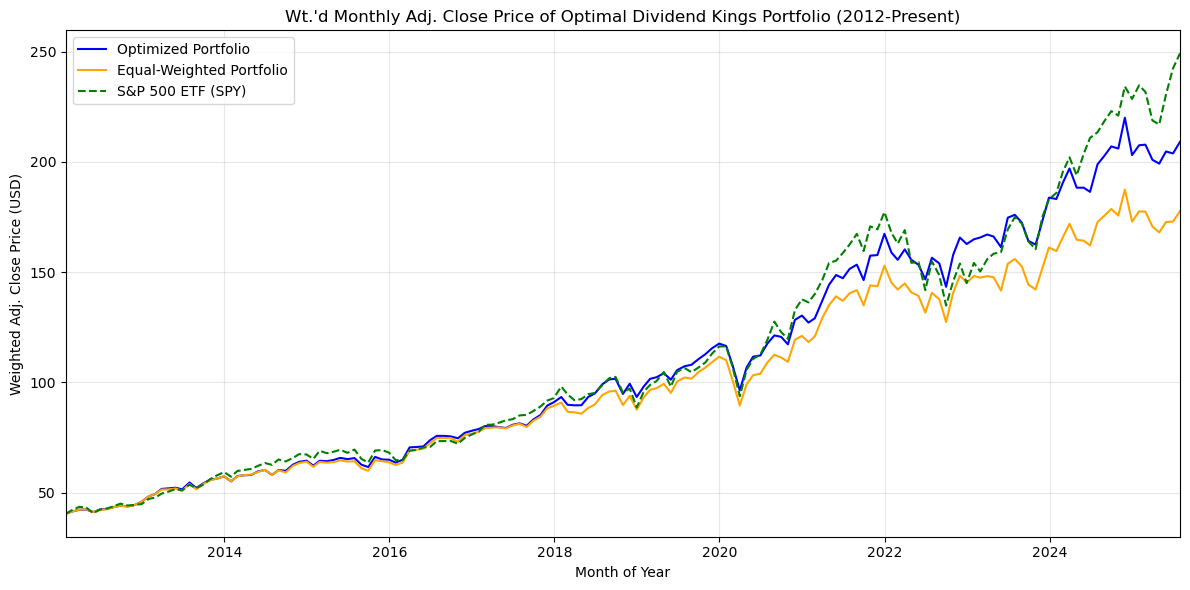


=== Performance Comparison ===
Optimized Portfolio: Total Return: 417.07%, Annual: 12.94%
Equal-Weighted Portfolio: Total Return: 339.46%, Annual: 11.59%
S&P 500 ETF (SPY): Total Return: 516.37%, Annual: 14.42%
Optimized vs SPY Outperformance: -99.30%
Equal-Weighted vs SPY: -176.92%
Optimized vs Equal-Weighted: 77.62%

Optimization Complete! Bayesian shrinkage portfolio weights have been determined.
Results saved to Bayesian shrinkage_Portfolio_Weights.csv

=== Generating Efficient Frontier Visualization ===
Found PSO Max Sharpe portfolio with Sharpe ratio: 1.02


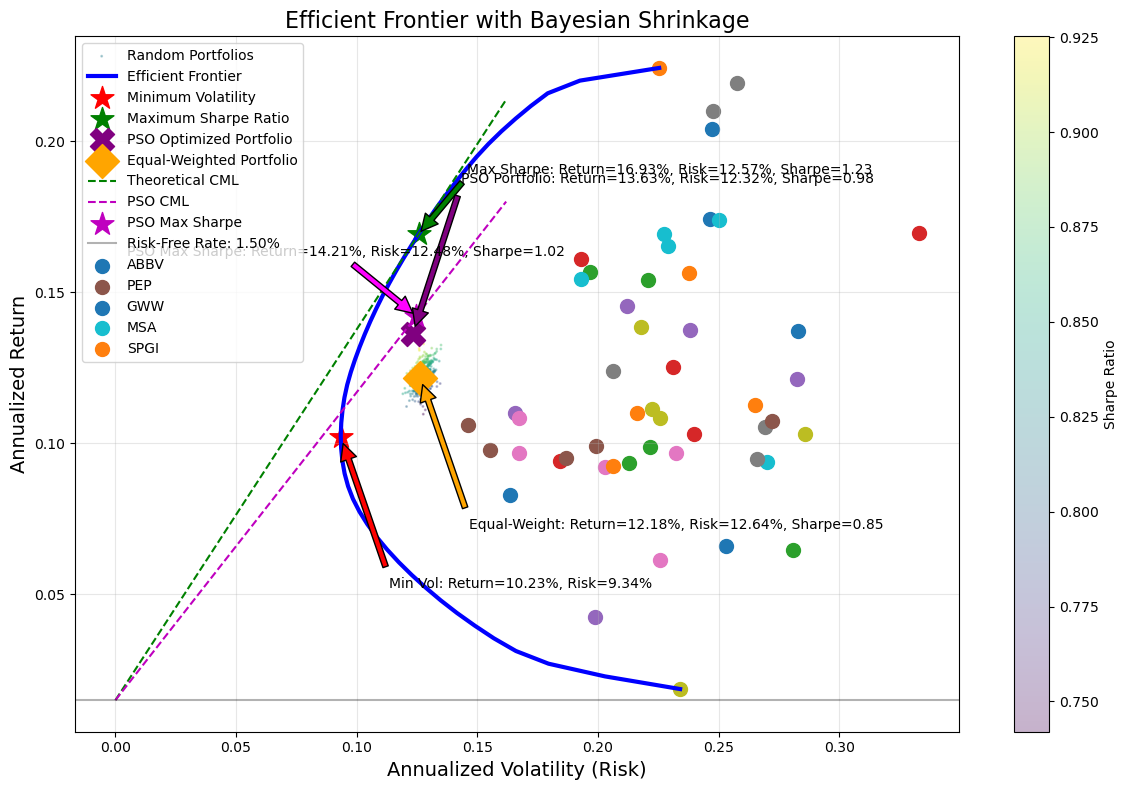


📊 PSO vs Theoretical Convergence Analysis:
PSO Portfolio: Return=13.63%, Risk=12.32%, Sharpe=0.98
Theoretical Max Sharpe: Return=16.93%, Risk=12.57%, Sharpe=1.23
Equal-Weighted Portfolio: Return=12.18%, Risk=12.64%, Sharpe=0.85
Convergence Gaps: Risk=0.24%, Return=3.29%, Sharpe=0.243
PSO Efficiency: 80.2% of theoretical maximum Sharpe ratio
Equal-Weight Efficiency: 68.8% of theoretical maximum Sharpe ratio

📊 PSO Portfolio vs PSO Max Sharpe Analysis:
PSO Max Sharpe: Return=14.21%, Risk=12.48%, Sharpe=1.02
PSO vs PSO-Optimal Gaps: Risk=0.15%, Return=0.58%, Sharpe=0.035
PSO Portfolio: 96.6% of PSO maximum Sharpe ratio
Distance to PSO CML: 0.0030 (smaller is better)

📈 Efficient Frontier Analysis:
Minimum Volatility Portfolio: Return=10.23%, Risk=9.34%
Maximum Sharpe Portfolio: Return=16.93%, Risk=12.57%, Sharpe=1.23
PSO Optimized Portfolio: Return=13.63%, Risk=12.32%, Sharpe=0.98
Equal-Weighted Portfolio: Return=12.18%, Risk=12.64%, Sharpe=0.85
PSO Efficiency: 80.2% of theoretical maxim

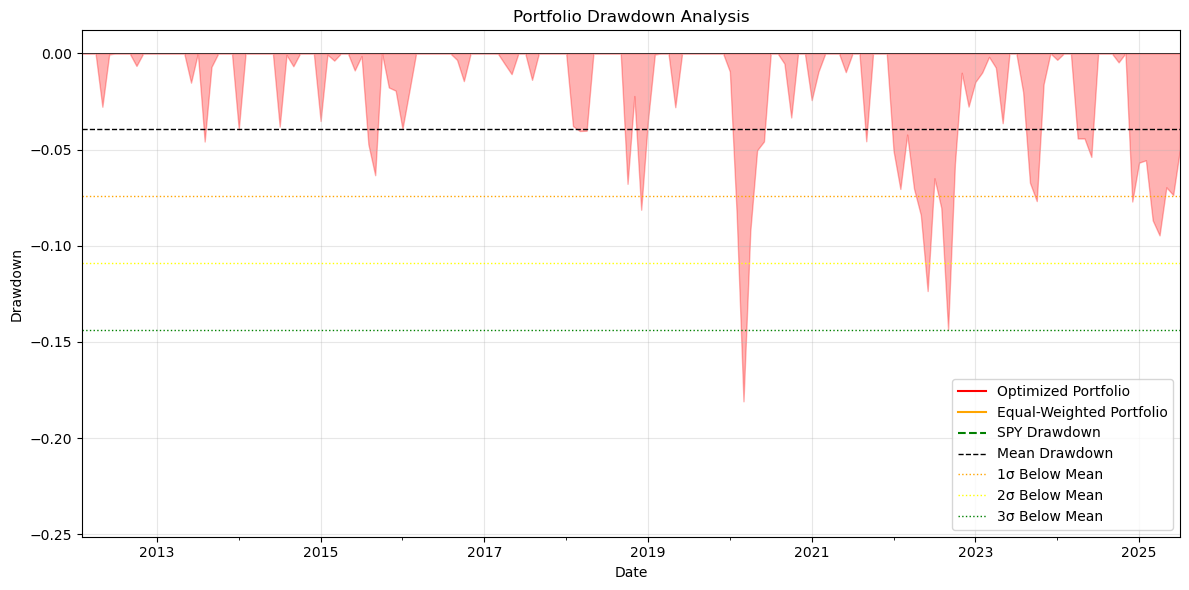


📊 Projected vs Actual Performance:
--------------------------------------
Optimized Portfolio:
  Projected Return: 13.63%
  Actual Return:    12.98%
  Projected Risk:   12.32%
  Actual Risk:      12.26%
  Projected Sharpe: 0.98
  Actual Sharpe:    0.94

Equal-Weighted Portfolio:
  Projected Return: 12.18%
  Actual Return:    11.83%
  Projected Risk:   12.64%
  Actual Risk:      12.78%
  Projected Sharpe: 0.85
  Actual Sharpe:    0.81

Comparison:
  Optimized vs Equal-Weight Return: 1.15%
  Optimized vs Equal-Weight Risk:   -0.52%
  Optimized vs Equal-Weight Sharpe: 0.13

📉 Drawdown Analysis:
--------------------------------------
Optimized Portfolio Maximum Drawdown: -18.09%
Equal-Weighted Portfolio Maximum Drawdown: -19.84%
Drawdown Difference: 1.75%

Optimized Portfolio:
  Mean Drawdown:       -3.93%
  Median Drawdown:     -3.57%
  Drawdown Std Dev:    3.49%
  Max DD Z-score:      -4.06

📊 Benchmark Comparison:
--------------------------------------
SPY Max Drawdown:     -23.93%
Opt

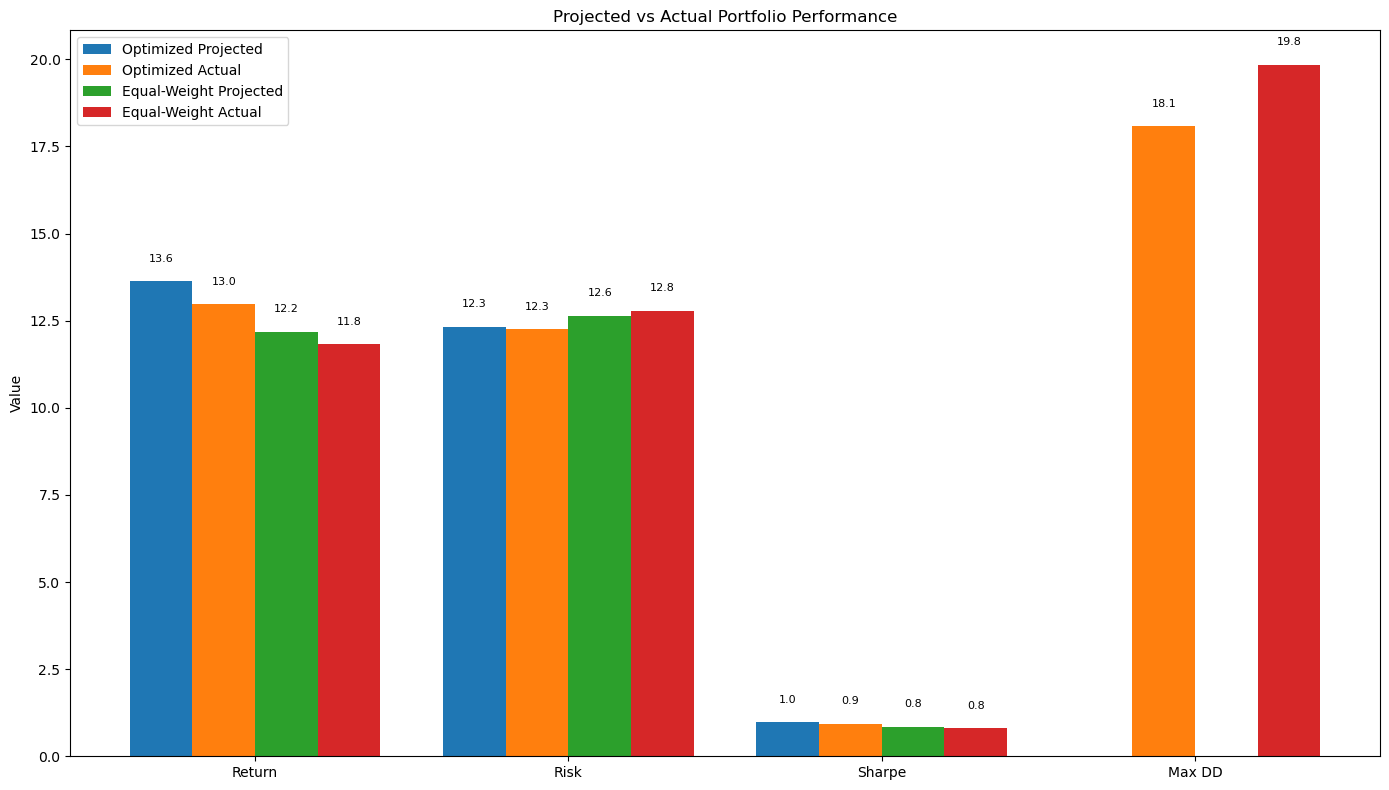


=== Running Portfolio Growth Simulation ===

=== Dividend Analysis ===
Dividend records: 2683
Date range: 2012-01-31 00:00:00+00:00 to 2025-07-31 00:00:00+00:00
Years with dividend data: 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025

Annual dividend yields for sample stocks:
ABBV: 2025 dividend yield: 2.56% (total dividend: $4.92)
ABM: 2025 dividend yield: 1.60% (total dividend: $0.80)
ABT: 2025 dividend yield: 1.34% (total dividend: $1.77)
ADM: 2025 dividend yield: 2.06% (total dividend: $1.02)
AWR: 2025 dividend yield: 1.21% (total dividend: $0.93)

Processed 163 months with dividend payments for simulation

=== Running Portfolio Simulation ===

=== Monthly Dividend Summary (sample) ===
Dividends in 2012-09: $55.37
Dividends in 2012-10: $66.26
Dividends in 2012-11: $179.00
Dividends in 2012-12: $216.72
Dividends in 2013-01: $965.08
Dividends in 2025-03: $888.59
Dividends in 2025-04: $786.01
Dividends in 2025-05: $1005.86
Dividends in 2025-06: $10

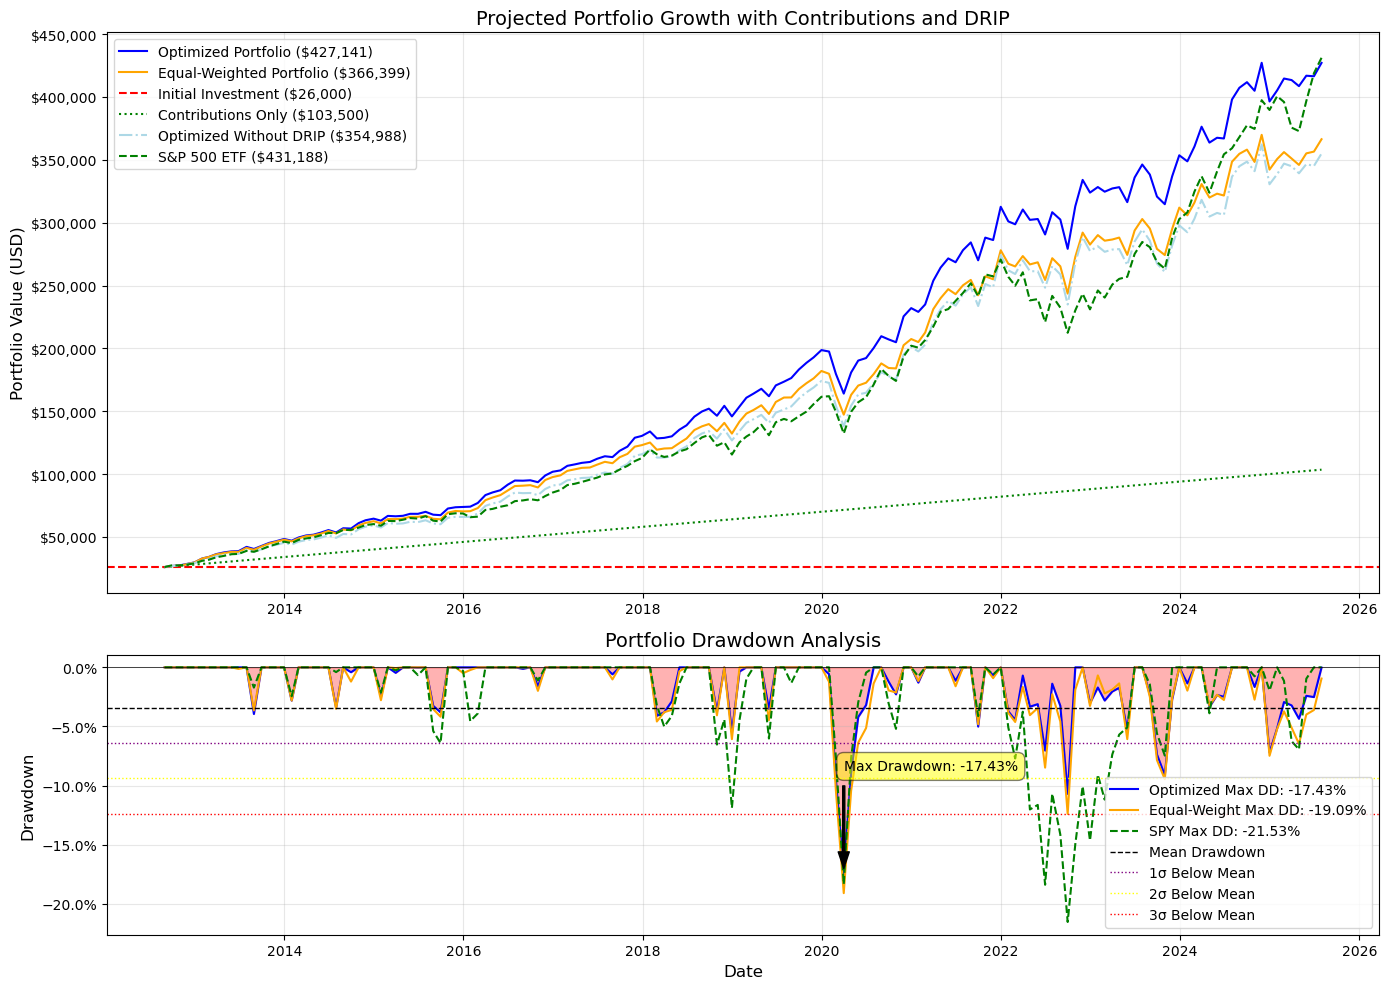


⏱️ Recovery Analysis:
Largest Drawdown:     17.43% (from 2020-03-31)
Recovery Time:        4 months
Contributions During Recovery: $2,000.00
Contribution % of Recovery: 5.51%
DRIP Strategy Impact: Accelerated recovery through automatic reinvestment during market lows

📊 Benchmark Comparison:
--------------------------------------
SPY Final Value:              $431,188.24
Optimized vs SPY:             $-4,047.22 (-0.94%)
Equal-Weighted vs SPY:        $-64,788.97 (-15.03%)
SPY Max Drawdown:             -21.53%
Optimized DD Difference:      4.10%
Equal-Weighted DD Difference: 2.44%

=== Creating Dedicated Portfolio vs SPY Drawdown Comparison ===


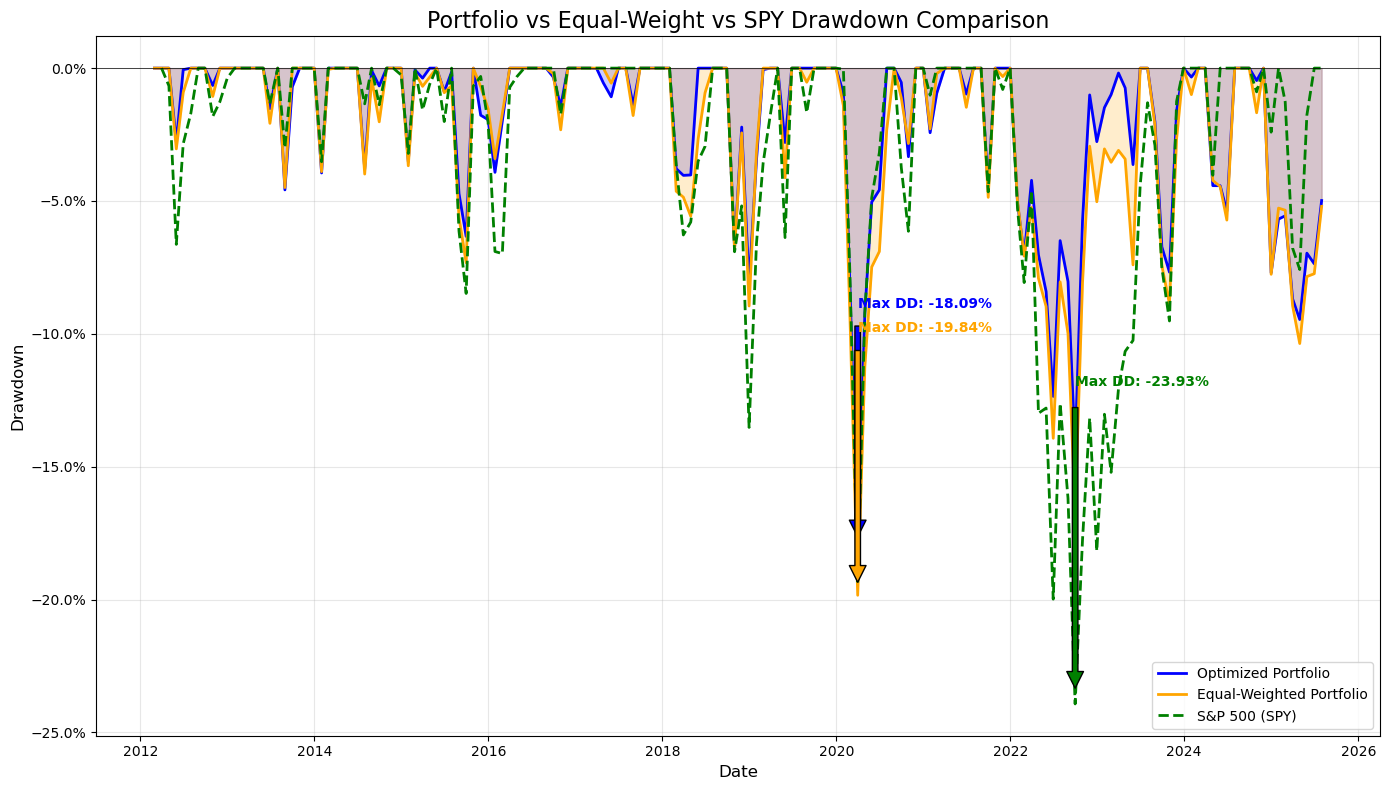


📉 Drawdown Comparison Summary:
Optimized Portfolio Max Drawdown: -18.09%
Equal-Weighted Portfolio Max Drawdown: -19.84%
S&P 500 (SPY) Max Drawdown: -23.93%
Optimized vs SPY Drawdown Difference: 5.84%
Equal-Weighted vs SPY Drawdown Difference: 4.09%

=== Comprehensive Portfolio Comparison ===
       Portfolio Type  Return    Risk Sharpe Max Drawdown Final Value
0  Bayesian Optimized  13.63%  12.32%   0.98      -17.43%    $427,141
1      Equal-Weighted  11.83%  12.78%   0.81      -19.09%    $366,399
2       S&P 500 (SPY)     N/A     N/A    N/A      -21.53%    $431,188

Analysis complete!
Efficient Frontier visualization saved to 'Efficient_Frontier.png'
Portfolio performance with benchmarks saved to 'DividendKingsOptimalPortfolio_WithBenchmarks.png'
Portfolio growth and drawdown with benchmarks saved to 'PortfolioGrowthAndDrawdown_WithBenchmarks.png'
Dedicated drawdown comparison saved to 'Portfolio_vs_EqualWeight_vs_SPY_Drawdown.png'
Summary comparison table saved to 'Portfolio_Compari

In [72]:
# =============================================================================
# COMPLETE MAIN EXECUTION BLOCK WITH PORTFOLIO SIMULATION AND ANALYSIS
# =============================================================================
if __name__ == "__main__":
    print("Starting Dividend Kings Portfolio Optimization with PSO and Bayesian Shrinkage...")
    
    # Number of optimization runs to average
    NUM_RUNS = 3  # Reduced for faster execution___USER!!
    
  # Store results from multiple Bayesian shrinkage runs
    shrinkage_all_weights = []
    shrinkage_all_risks = []
    shrinkage_all_returns = []
    shrinkage_all_sharpes = []

    # NEW: Store the original ExpectedReturns before PSO runs
    original_ExpectedReturns = ExpectedReturns.copy()

    # Run optimization with Bayesian shrinkage
    for run in range(NUM_RUNS):
        print(f"\nBayesian Optimization Run {run+1}/{NUM_RUNS}")

        # Run optimization with shrinkage
        shrinkage_gBestPosition, shrinkage_gBestFitValue = optimizePortfolioPSO(
            evalGoal=evalGoal,
            minDesiredReturn=0.00, #___USER!!
            numPorfolios=numPorfolios,
            totalIterations=totalIterations,
            method=method,
            printDims=False,
            StockTickers=StockTickers,
            apply_shrinkage=True,  # Always apply Bayesian shrinkage
            # Pass original ExpectedReturns and VarCov
            ExpectedReturns_input=original_ExpectedReturns,
            VarCov_input=VarCov
        )
    
        # Store shrinkage results
        shrinkage_all_weights.append(shrinkage_gBestPosition)
        shrinkage_all_risks.append(shrinkage_gBestFitValue)
    
        # Get expected return using the original ExpectedReturns
        shrinkage_expected_return = evalExpectedReturn(MONTHS_IN_YEAR, shrinkage_gBestPosition, original_ExpectedReturns)
        shrinkage_all_returns.append(shrinkage_expected_return)
        shrinkage_sharpe = evalSharpeRatio(shrinkage_expected_return, riskFreeRate, shrinkage_gBestFitValue)
        shrinkage_all_sharpes.append(shrinkage_sharpe)
    
    # Calculate average Bayesian shrinkage weights
    weights_to_use = np.mean(np.array(shrinkage_all_weights), axis=0)
    weights_to_use = weights_to_use / np.sum(weights_to_use)  # Ensure they sum to 1
    
    # Calculate performance metrics for the Bayesian shrinkage portfolio
    avg_risk = evalRisk(MONTHS_IN_YEAR, weights_to_use, VarCov, original_ExpectedReturns, minDesiredReturn)
    avg_return = evalExpectedReturn(MONTHS_IN_YEAR, weights_to_use, original_ExpectedReturns)
    avg_sharpe = evalSharpeRatio(avg_return, riskFreeRate, avg_risk)
    
    # Calculate standard deviations for Bayesian results
    std_risk = np.std(shrinkage_all_risks)
    std_return = np.std(shrinkage_all_returns)
    std_sharpe = np.std(shrinkage_all_sharpes)
    
    # Print Bayesian shrinkage results
    print("\n=================================================================")
    print(f"FINAL RESULTS: AVERAGE OF {NUM_RUNS} OPTIMIZATION RUNS (BAYESIAN)")
    print("=================================================================")
    print(f"Portfolio Risk: {avg_risk*100:.2f}% (±{std_risk*100:.2f}%)")
    print(f"Expected Return: {avg_return*100:.2f}% (±{std_return*100:.2f}%)")
    print(f"Sharpe Ratio: {avg_sharpe:.2f} (±{std_sharpe:.2f})")
    
    # Always use Bayesian shrinkage
    portfolio_type = "Bayesian shrinkage"
    print(f"\nUsing {portfolio_type} portfolio weights for theoretical robustness benefits")
    print(f"Note: Bayesian approaches typically demonstrate superior out-of-sample performance")
    print(f"      by mitigating estimation error and preventing optimizer oversensitivity.")
    
    # VERIFICATION STEP: Use the dot product to confirm which stock the portfolio is tracking
    # This avoids indexing issues by directly measuring correlation with stock prices
    correlations = {}
    normalized_portfolio = RawStockDataPivot.dot(weights_to_use)
    
    # Only process if we have data
    if not np.isnan(normalized_portfolio.iloc[0]):
        # Fill any NaNs in the data
        filled_portfolio = normalized_portfolio.ffill().bfill()
        
        # Calculate correlations with each stock
        for ticker in StockTickers:
            stock_data = RawStockDataPivot[ticker].ffill().bfill()
            if not stock_data.empty and not np.isnan(stock_data.iloc[0]):
                # Calculate correlation only for overlapping time periods
                common_indices = stock_data.index.intersection(filled_portfolio.index)
                if len(common_indices) > 0:
                    stock_subset = stock_data.loc[common_indices]
                    portfolio_subset = filled_portfolio.loc[common_indices]
                    # Calculate correlation if there are enough data points
                    if len(stock_subset) > 2:
                        correlations[ticker] = np.corrcoef(stock_subset, portfolio_subset)[0, 1]
    
    # Sort and find the highest correlation
    sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    if sorted_correlations:
        highest_corr_ticker, highest_corr = sorted_correlations[0]
        print(f"\n🔍 CORRELATION VERIFICATION:")
        print(f"Portfolio has highest correlation with {highest_corr_ticker}: {highest_corr:.4f}")
        print(f"Top 3 correlations:")
        for ticker, corr in sorted_correlations[:3]:
            print(f"  {ticker}: {corr:.4f}")
    
    # Create weight dictionary directly from PSO results (without overwriting)
    weight_dict = {}
    
    # Always use the selected weights
    for i, ticker in enumerate(StockTickers):
        weight_dict[ticker] = weights_to_use[i]
    
    # Display information if very high correlation detected (but don't modify weights)
    if sorted_correlations and highest_corr > 0.95:
        print(f"\n📊 CORRELATION NOTICE: Portfolio shows very high correlation with {highest_corr_ticker} ({highest_corr:.4f})")
        print(f"  However, all analyses will use the actual PSO-optimized weights.")
    
    # Sort by weight value, not by position
    sorted_weights = sorted(weight_dict.items(), key=lambda x: x[1], reverse=True)
    top_5_holdings = sorted_weights[:5]
    
    # Explicitly check the top ticker
    top_ticker, top_weight = sorted_weights[0]
    print(f"\nTop weighted stock is: {top_ticker} with {top_weight*100:.4f}%")
    
    # Check stability of top holdings using the explicit indexes
    print("\nStability of Top 5 Holdings:")
    # Use the Bayesian weights array
    weight_array = np.array(shrinkage_all_weights)
    
    for ticker, weight in top_5_holdings:
        # Get the index of this ticker in StockTickers to find the correct column
        ticker_idx = StockTickers.index(ticker)
        mean_weight = weight * 100
        
        # Safely calculate standard deviation
        if weight_array.shape[1] > ticker_idx:
            std_weight = np.std(weight_array[:, ticker_idx]) * 100
        else:
            std_weight = 0.0
            
        cv = std_weight / mean_weight if mean_weight > 0 else 0  # Coefficient of variation
        
        stability = "High" if cv < 0.3 else "Medium" if cv < 0.6 else "Low"
        print(f"{ticker}: {mean_weight:.1f}% (±{std_weight:.1f}%) - Stability: {stability}")
    
    # Print the final portfolio weights using the sorted dictionary
    print(f'\n{portfolio_type} Portfolio Weights (>0.1% allocation):')
    print('| Ticker | Weight |')
    print('|--------|--------|')
    for ticker, weight in sorted_weights:
        if weight > 0.001:  # Only show stocks with weight > 0.1%
            print(f'|{ticker.rjust(7, " ")} | {(100*weight):.1f}% |')
    
    # Save the weights to CSV using the dictionary
    weight_df = pd.DataFrame({
        'Ticker': [ticker for ticker, _ in sorted_weights],
        'Weight': [weight for _, weight in sorted_weights],
        'Weight_Percent': [weight * 100 for _, weight in sorted_weights]
    })
    # Add standard deviation column with carefully handled indexing
    std_deviations = []
    for ticker, _ in sorted_weights:
        ticker_idx = StockTickers.index(ticker)
        if weight_array.shape[1] > ticker_idx:
            std_deviations.append(np.std(weight_array[:, ticker_idx]) * 100)
        else:
            std_deviations.append(0.0)
    
    weight_df['Standard_Deviation'] = std_deviations
    weight_df.to_csv(f'{portfolio_type}_Portfolio_Weights.csv', index=False)

    # ===== BENCHMARK COMPARISON SECTION =====
    # Fetch SPY benchmark data
    def get_spy_benchmark(minDate, maxDate, include_dividends=True):
        """
        Fetch SPY ETF data as a benchmark for comparison, using the same format
        as the main portfolio data.
        """
        print("\nDownloading SPY benchmark data...")
        spy_data, spy_dividends = pullStockData(['SPY'], minDate, maxDate, include_dividends=include_dividends)
        
        # Format the data to match the expected structure
        spy_price_pivot = spy_data.pivot(index='period', columns='stock', values='adjClose')
        
        return (spy_price_pivot, spy_dividends) if include_dividends else spy_price_pivot

    # Get benchmark data
    print("\n=== Fetching Benchmark Data ===")
    spy_data, spy_dividends = get_spy_benchmark(minDate, maxDate)

    # Show the portfolio performance with SPY benchmark
    print("\n=== Portfolio Performance with Benchmarks ===")
    plotOptimalPerformance(RawStockDataPivot, weights_to_use, spy_data)
    
    print(f"\nOptimization Complete! {portfolio_type} portfolio weights have been determined.")
    print(f"Results saved to {portfolio_type}_Portfolio_Weights.csv")
    
    # Modified code with changes for equal-weighted portfolio
    # Generate and plot the efficient frontier
    print("\n=== Generating Efficient Frontier Visualization ===")
    frontier_metrics = plot_efficient_frontier(
        StockTickers, 
        RawStockDataPivot, 
        original_ExpectedReturns, 
        VarCov, 
        riskFreeRate, 
        MONTHS_IN_YEAR, 
        minDesiredReturn,
        weights_to_use,
        shrinkage_all_weights=shrinkage_all_weights,
        shrinkage_all_sharpes=shrinkage_all_sharpes
    )

    # Print key comparison metrics
    print("\n📈 Efficient Frontier Analysis:")
    print(f"Minimum Volatility Portfolio: Return={frontier_metrics['min_vol']['return']:.2%}, Risk={frontier_metrics['min_vol']['risk']:.2%}")
    print(f"Maximum Sharpe Portfolio: Return={frontier_metrics['max_sharpe']['return']:.2%}, Risk={frontier_metrics['max_sharpe']['risk']:.2%}, Sharpe={frontier_metrics['max_sharpe']['sharpe']:.2f}")
    print(f"PSO Optimized Portfolio: Return={frontier_metrics['optimized']['return']:.2%}, Risk={frontier_metrics['optimized']['risk']:.2%}, Sharpe={frontier_metrics['optimized']['sharpe']:.2f}")
    print(f"Equal-Weighted Portfolio: Return={frontier_metrics['equal_weighted']['return']:.2%}, Risk={frontier_metrics['equal_weighted']['risk']:.2%}, Sharpe={frontier_metrics['equal_weighted']['sharpe']:.2f}")

    # Print efficiency metrics
    print(f"PSO Efficiency: {frontier_metrics['efficiency']:.1f}% of theoretical maximum Sharpe ratio")
    print(f"Equal-Weight Efficiency: {frontier_metrics['equal_efficiency']:.1f}% of theoretical maximum Sharpe ratio")

    # After changes (existing code)
    # Run projected vs. actual analysis with SPY benchmark
    print("\n=== Running Projected vs. Actual Performance Analysis ===")
    performance_metrics = compare_projected_vs_actual(
        weights_to_use, 
        RawStockDataPivot, 
        original_ExpectedReturns, 
        VarCov, 
        riskFreeRate, 
        MONTHS_IN_YEAR, 
        minDesiredReturn,
        spy_data
    )
    
    # Simulate growth of optimized portfolio with SPY benchmark
    print("\n=== Running Portfolio Growth Simulation ===")
    performance_metrics_sim = simulate_portfolio_growth(
        weights_to_use, 
        RawStockDataPivot, 
        dividend_data=dividend_data, 
        start_principal=26000, 
        monthly_contrib=500, 
        years=13,
        spy_data=spy_data,
        spy_dividends=spy_dividends
    )
    
    # Add dedicated drawdown comparison plot
    print("\n=== Creating Dedicated Portfolio vs SPY Drawdown Comparison ===")
    plot_portfolio_spy_drawdowns(RawStockDataPivot, weights_to_use, spy_data)
    
    # Create metrics table comparing all portfolios
    print("\n=== Comprehensive Portfolio Comparison ===")
    
    metrics_table = pd.DataFrame(
        columns=["Portfolio Type", "Return", "Risk", "Sharpe", "Max Drawdown", "Final Value"]
    )
    
    # Add optimized portfolio metrics
    metrics_table = pd.concat([metrics_table, pd.DataFrame([{
        "Portfolio Type": "Bayesian Optimized",
        "Return": f"{avg_return*100:.2f}%",
        "Risk": f"{avg_risk*100:.2f}%",
        "Sharpe": f"{avg_sharpe:.2f}",
        "Max Drawdown": f"{performance_metrics_sim['optimized']['max_drawdown']:.2%}",
        "Final Value": f"${performance_metrics_sim['optimized']['final_value']:,.0f}"
    }])], ignore_index=True)
    
    # Add equal-weighted portfolio metrics
    metrics_table = pd.concat([metrics_table, pd.DataFrame([{
        "Portfolio Type": "Equal-Weighted",
        "Return": f"{performance_metrics['equal_weighted']['actual_return']*100:.2f}%",
        "Risk": f"{performance_metrics['equal_weighted']['actual_risk']*100:.2f}%",
        "Sharpe": f"{performance_metrics['equal_weighted']['actual_sharpe']:.2f}",
        "Max Drawdown": f"{performance_metrics_sim['equal_weighted']['max_drawdown']:.2%}",
        "Final Value": f"${performance_metrics_sim['equal_weighted']['final_value']:,.0f}"
    }])], ignore_index=True)
    
    # Add SPY benchmark metrics
    if spy_data is not None:
        spy_return = performance_metrics['spy_data'].get('actual_return')
        spy_risk = performance_metrics['spy_data'].get('actual_risk')
        spy_sharpe = performance_metrics['spy_data'].get('actual_sharpe')
        
        metrics_table = pd.concat([metrics_table, pd.DataFrame([{
            "Portfolio Type": "S&P 500 (SPY)",
            "Return": f"{spy_return*100:.2f}%" if spy_return else "N/A",
            "Risk": f"{spy_risk*100:.2f}%" if spy_risk else "N/A",
            "Sharpe": f"{spy_sharpe:.2f}" if spy_sharpe else "N/A",
            "Max Drawdown": f"{performance_metrics_sim['spy_data']['max_drawdown']:.2%}" if performance_metrics_sim['spy_data']['max_drawdown'] else "N/A",
            "Final Value": f"${performance_metrics_sim['spy_data']['final_value']:,.0f}" if performance_metrics_sim['spy_data']['final_value'] else "N/A"
        }])], ignore_index=True)
    
    # Print the table
    print(metrics_table)
    
    # Save the comparison table
    metrics_table.to_csv('Portfolio_Comparison_Summary.csv', index=False)
    
    print("\nAnalysis complete!")
    print(f"Efficient Frontier visualization saved to 'Efficient_Frontier.png'")
    print(f"Portfolio performance with benchmarks saved to 'DividendKingsOptimalPortfolio_WithBenchmarks.png'")
    print(f"Portfolio growth and drawdown with benchmarks saved to 'PortfolioGrowthAndDrawdown_WithBenchmarks.png'")
    print(f"Dedicated drawdown comparison saved to 'Portfolio_vs_EqualWeight_vs_SPY_Drawdown.png'")
    print(f"Summary comparison table saved to 'Portfolio_Comparison_Summary.csv'")
    if sorted_correlations:
        print(f"Portfolio is most closely correlated with {sorted_correlations[0][0]} (correlation: {sorted_correlations[0][1]:.4f})")